# Test 4: SGNS Only Drift and Sanity Suite (HistWords Focus, Alignment Checks, and Drift Signals)

This notebook isolates HistWords SGNS and evaluates drift behavior with updated weights. Effectivley the same test as 2 with esxtra steps. 



In [1]:
# If you run this in a fresh environment, uncomment:
# !pip install numpy pandas matplotlib scipy

from pathlib import Path
from typing import Dict, List, Tuple, Optional
import re, glob, pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes

pd.set_option("display.max_colwidth", 180)


## 0) Config

In [2]:
# Your path (Windows)
SGNS_DIR = Path(r"G:\My Drive\ThesisMaterial\Computation\data\sgns")

# Neighbor inspection
K_NEIGHBORS = 150
KEEP_K = 12

# Alignment config
N_ANCHORS = 5000
ANCHOR_SEED = 7

# Anchor presence requirement (fraction of decades).
# If alignment drops many decades, lower this (e.g., 0.4).
ANCHOR_MIN_FRAC = 0.6

# Spectering config (time-mixing)
SPECTER_WEIGHTING = "exponential_decay"   # "exponential_decay" or "recency_bias"
SPECTER_ALPHA = 0.5 ** (1/3)            # half-life = 3 decades
SPECTER_MIN_WEIGHT = 0.01           # include farther decades


## 1) Loaders + alignment



In [3]:
def normalize_rows(W: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    W = W.astype(np.float32, copy=False)
    norms = np.linalg.norm(W, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return W / norms

def _find_file_for_decade(directory: Path, decade: int, exts: Tuple[str,...]) -> Optional[Path]:
    pats = [str(directory / f"*{decade}*{ext}") for ext in exts]
    hits = []
    for pat in pats:
        hits.extend([Path(p) for p in glob.glob(pat)])
    hits = sorted(hits, key=lambda p: (len(p.name), p.name))
    return hits[0] if hits else None

def list_sgns_decades(sgns_dir: Path) -> List[int]:
    if not sgns_dir.exists():
        return []
    decades = set()
    for p in sgns_dir.glob("*.npy"):
        m = re.search(r"(\d{4})", p.name)
        if m:
            y = int(m.group(1))
            if y % 10 == 0:
                decades.add(y)
    return sorted(decades)

def load_sgns_decade(decade: int, sgns_dir: Path) -> Tuple[np.ndarray, List[str], Dict[str,int]]:
    w_path = _find_file_for_decade(sgns_dir, decade, (".npy",))
    v_path = _find_file_for_decade(sgns_dir, decade, (".pkl", ".pickle"))
    if w_path is None or v_path is None:
        raise FileNotFoundError(f"Missing SGNS files for {decade} in {sgns_dir} (need .npy + vocab .pkl/.pickle)")

    W = normalize_rows(np.load(str(w_path)))
    with open(v_path, "rb") as f:
        vocab = list(pickle.load(f))

    if len(vocab) != W.shape[0]:
        raise ValueError(
            f"{decade}: vocab length {len(vocab)} != W rows {W.shape[0]} for {w_path.name}. "
            "This usually means the vocab file doesn't match the .npy file for that decade."
        )

    w2i = {w:i for i,w in enumerate(vocab)}
    return W, vocab, w2i

def build_alignment(load_fn, decades: List[int], ref_decade: int, stable_words: List[str]):
    """Align every decade to ref_decade via orthogonal Procrustes on shared anchors."""
    W_ref, vocab_ref, w2i_ref = load_fn(ref_decade)
    anchors = [w for w in stable_words if w in w2i_ref]
    if len(anchors) < 8:
        raise RuntimeError(f"Too few anchors present in reference decade {ref_decade}: {len(anchors)}")

    aligned = {}
    for d in decades:
        W, vocab, w2i = load_fn(d)
        shared = [w for w in anchors if w in w2i]
        if len(shared) < 8:
            continue

        idx_d   = np.array([w2i[w] for w in shared], dtype=int)
        idx_ref = np.array([w2i_ref[w] for w in shared], dtype=int)

        A_d   = W[idx_d]
        A_ref = W_ref[idx_ref]

        R, _ = orthogonal_procrustes(A_d, A_ref)
        W_aligned = normalize_rows(W @ R)
        aligned[d] = (W_aligned, vocab, w2i)

    return aligned


## 2) Anchor selection 

In [4]:
def is_ok_anchor(w: str) -> bool:
    if len(w) < 2 or len(w) > 60:
        return False
    if " " in w:
        return False
    return True

def build_anchors_by_ref_intersection(
    load_fn,
    decades: List[int],
    ref_decade: int,
    n_anchors: int = 5000,
    seed: int = 7,
    min_frac: float = 0.6,
) -> List[str]:
    W_ref, vocab_ref, w2i_ref = load_fn(ref_decade)
    ref_words = [w for w in vocab_ref if is_ok_anchor(w)]
    ref_set = set(ref_words)

    counts = {w: 0 for w in ref_words}
    for d in decades:
        W, vocab, w2i = load_fn(d)
        for w in ref_set:
            if w in w2i:
                counts[w] += 1

    need = max(8, int(np.ceil(min_frac * len(decades))))
    eligible = [w for w, c in counts.items() if c >= need]

    # Fallback: intersect ref with the median decade
    if len(eligible) < 50:
        mid = decades[len(decades)//2]
        W_mid, vocab_mid, w2i_mid = load_fn(mid)
        eligible = [w for w in ref_words if w in w2i_mid]

    if len(eligible) < 8:
        raise RuntimeError(
            f"Too few anchors after fallbacks: {len(eligible)}. "
            "Likely vocab mismatch across decades (wrong .pkl paired with .npy) or extremely disjoint vocabs."
        )

    rng = np.random.default_rng(seed)
    if len(eligible) > n_anchors:
        eligible = list(rng.choice(eligible, size=n_anchors, replace=False))
    return eligible


## 3) Discover decades + build aligned baseline SGNS


In [5]:
sgns_decades = list_sgns_decades(SGNS_DIR)
if not sgns_decades:
    raise RuntimeError(f"No SGNS decades found in {SGNS_DIR}. Check filenames (.npy + vocab .pkl/.pickle).")

print("SGNS decades:", sgns_decades)

REF_DECADE = sgns_decades[-1]
print("REF_DECADE:", REF_DECADE)

# Quick diagnostic: show which files are being paired for a few decades
print("\nFile pairing check (first 6 decades):")
for d in sgns_decades[:6]:
    w_path = _find_file_for_decade(SGNS_DIR, d, (".npy",))
    v_path = _find_file_for_decade(SGNS_DIR, d, (".pkl",".pickle"))
    print(d, "|", (w_path.name if w_path else None), "|", (v_path.name if v_path else None))

anchors = build_anchors_by_ref_intersection(
    load_fn=lambda d: load_sgns_decade(d, SGNS_DIR),
    decades=sgns_decades,
    ref_decade=REF_DECADE,
    n_anchors=N_ANCHORS,
    seed=ANCHOR_SEED,
    min_frac=ANCHOR_MIN_FRAC,
)
print("\nn_anchors:", len(anchors))

sgns_aligned = build_alignment(
    load_fn=lambda d: load_sgns_decade(d, SGNS_DIR),
    decades=sgns_decades,
    ref_decade=REF_DECADE,
    stable_words=anchors,
)

SGNS_DECADES_ALIGNED = sorted(sgns_aligned.keys())
print("Aligned decades:", SGNS_DECADES_ALIGNED)


SGNS decades: [1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920]
REF_DECADE: 1920

File pairing check (first 6 decades):
1800 | 1800-w.npy | 1800-vocab.pkl
1810 | 1810-w.npy | 1810-vocab.pkl
1820 | 1820-w.npy | 1820-vocab.pkl
1830 | 1830-w.npy | 1830-vocab.pkl
1840 | 1840-w.npy | 1840-vocab.pkl
1850 | 1850-w.npy | 1850-vocab.pkl

n_anchors: 5000
Aligned decades: [1800, 1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920]


## 4) Build spectered SGNS (time-mixed) and compare to baseline


In [6]:
def load_spectered_from_aligned(
    aligned: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
    decades_ordered: List[int],
    weighting_scheme: str = "exponential_decay",
    alpha: float = 0.7,
    min_weight: float = 0.05,
) -> Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]]:
    """Create a spectered version: each decade vector is a weighted mix of current+past aligned decades."""
    decades_ordered = [d for d in decades_ordered if d in aligned]
    if not decades_ordered:
        raise RuntimeError("No decades available in aligned dict for spectering.")

    spectered = {}
    for i, cur_dec in enumerate(decades_ordered):
        W_cur, vocab_cur, w2i_cur = aligned[cur_dec]
        W_spec = np.zeros_like(W_cur)

        if weighting_scheme == "recency_bias":
            denom = (i + 1) * (i + 2) / 2.0  # 1+2+...+(i+1)

        for word in vocab_cur:
            idx_cur = w2i_cur[word]
            v_acc = np.zeros(W_cur.shape[1], dtype=np.float32)
            w_acc = 0.0

            for j in range(i + 1):
                past_dec = decades_ordered[j]
                W_p, vocab_p, w2i_p = aligned[past_dec]
                if word not in w2i_p:
                    continue

                if weighting_scheme == "exponential_decay":
                    dist = i - j
                    w = alpha ** dist
                    w = max(w, min_weight)
                elif weighting_scheme == "recency_bias":
                    w = (j + 1) / denom
                else:
                    raise ValueError("Unknown weighting_scheme")

                v_acc += w * W_p[w2i_p[word]]
                w_acc += w

            if w_acc > 0:
                W_spec[idx_cur] = v_acc / w_acc

        spectered[cur_dec] = (normalize_rows(W_spec), vocab_cur, w2i_cur)

    return spectered

sgns_spectered = load_spectered_from_aligned(
    aligned=sgns_aligned,
    decades_ordered=SGNS_DECADES_ALIGNED,
    weighting_scheme=SPECTER_WEIGHTING,
    alpha=SPECTER_ALPHA,
    min_weight=SPECTER_MIN_WEIGHT,
)

print("Built spectered SGNS for decades:", sorted(sgns_spectered.keys())[:5], "...", sorted(sgns_spectered.keys())[-5:])


Built spectered SGNS for decades: [1800, 1810, 1820, 1830, 1840] ... [1880, 1890, 1900, 1910, 1920]


## 5) Evaluation utilities 


In [7]:
# Display-token filter: looser than anchors, but avoids obvious junk in tables.
RE_HAS_DIGIT = re.compile(r"\d")
RE_BAD = re.compile(r"[^a-zA-Z_\-']")  # allow underscores/hyphen/apostrophe

def is_good_display_token(w: str) -> bool:
    if w is None:
        return False
    if len(w) < 2 or len(w) > 40:
        return False
    if RE_HAS_DIGIT.search(w):
        return False
    if RE_BAD.search(w):
        return False
    return True

def topk_neighbors(W: np.ndarray, vocab: List[str], w2i: Dict[str,int], term: str, k: int = 25) -> List[Tuple[str, float]]:
    if term not in w2i:
        return []
    i = w2i[term]
    v = W[i]
    sims = W @ v
    sims[i] = -np.inf
    k_eff = min(k, len(sims)-1)
    idx = np.argpartition(sims, -k_eff)[-k_eff:]
    idx = idx[np.argsort(-sims[idx])]
    return [(vocab[j], float(sims[j])) for j in idx]

def clean_neighbors(neigh: List[Tuple[str, float]], keep_k: int = 12) -> List[str]:
    out = []
    for w, _ in neigh:
        if is_good_display_token(w):
            out.append(w)
        if len(out) >= keep_k:
            break
    return out

def neighbor_trail(term: str,
                   emb: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
                   k: int = 75,
                   keep_k: int = 12) -> pd.DataFrame:
    rows = []
    for d,(W,vocab,w2i) in sorted(emb.items()):
        neigh = clean_neighbors(topk_neighbors(W, vocab, w2i, term, k=k), keep_k=keep_k)
        rows.append({"decade": d, "neighbors": ", ".join(neigh)})
    return pd.DataFrame(rows)

def neighbor_overlap(term: str,
                     emb: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
                     k: int = 100,
                     keep_k: int = 25) -> pd.DataFrame:
    decades = sorted(emb.keys())
    rows = []
    prev = None
    prev_dec = None
    for d in decades:
        W,vocab,w2i = emb[d]
        neigh = clean_neighbors(topk_neighbors(W, vocab, w2i, term, k=k), keep_k=keep_k)
        s = set(neigh)
        if prev is not None and len(s) > 0:
            jacc = len(prev & s) / max(len(prev | s), 1)
            rows.append({"decade": d, "prev_decade": prev_dec, "jaccard": float(jacc)})
        prev = s
        prev_dec = d
    return pd.DataFrame(rows)

def adjacent_change(term: str,
                    emb: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]]) -> pd.DataFrame:
    decades = sorted(emb.keys())
    rows = []
    prev_vec = None
    prev_dec = None
    for d in decades:
        W,vocab,w2i = emb[d]
        if term not in w2i:
            prev_vec, prev_dec = None, None
            continue
        v = W[w2i[term]]
        if prev_vec is not None:
            rows.append({"decade": d, "prev_decade": prev_dec, "cos_to_prev": float(v @ prev_vec)})
        prev_vec, prev_dec = v, d
    return pd.DataFrame(rows)

def plot_two_series(df_a: pd.DataFrame, df_b: pd.DataFrame, x: str, y: str, label_a: str, label_b: str, title: str):
    plt.figure()
    if not df_a.empty:
        plt.plot(df_a[x], df_a[y], marker="o", label=label_a)
    if not df_b.empty:
        plt.plot(df_b[x], df_b[y], marker="o", label=label_b)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()

def coverage(term: str, emb) -> int:
    return sum(1 for _,(_,_,w2i) in emb.items() if term in w2i)


## 6) baseline SGNS vs spectered SGNS



TERM: master | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"masters, mistress, wardens, owner, ordnance, apprentice, deputy, requests, chamberlain, provost, assistants, rolls"
1,1810,"masters, mistress, overseer, wardrobe, fellows, wardens, school, adjutant, deputy, warden, emanuel, mate"
2,1820,"mistress, masters, wardens, holdenough, kerneguy, wildrake, employer, adjutant, tomkins, commands, fellows, bridgenorth"
3,1830,"masters, mistress, owner, bates, employer, wardens, bridgenorth, worshipful, fellows, chiffinch, provost, overseer"
4,1840,"mistress, masters, owner, mastership, worshipful, innkeeper, deputy, sutton, servant, patron, provost, ruthven"
5,1850,"masters, mistress, seadrift, servant, owner, mastership, calatrava, worshipful, employer, chiffinch, crib, overseer"
6,1860,"masters, mistress, mate, servant, worshipful, employer, steward, owner, assistant, mastership, balliol, art"
7,1870,"masters, mistress, mate, worshipful, owner, servant, rugby, assistant, apprentice, servants, employer, patron"
8,1880,"masters, mistress, taylors, charterhouse, calatrava, rugby, assistant, hospitallers, worshipful, tutor, patron, servant"
9,1890,"mistress, masters, rugby, steward, holdenough, bally, assistant, charterhouse, kerneguy, foreman, worshipful, mate"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"masters, mistress, wardens, owner, ordnance, apprentice, deputy, requests, chamberlain, provost, assistants, rolls"
1,1810,"masters, mistress, wardens, apprentice, fellows, provost, mate, school, barber, chamberlain, deputy, ordnance"
2,1820,"masters, mistress, wardens, apprentice, fellows, senior, chaplain, mate, deputy, provost, overseer, emanuel"
3,1830,"masters, wardens, mistress, steward, employer, senior, fellows, overseer, provost, apprentice, assistant, owner"
4,1840,"mistress, masters, wardens, worshipful, steward, apprentice, assistant, provost, senior, owner, overseer, chamberlain"
5,1850,"mistress, masters, worshipful, wardens, mastership, apprentice, servant, warden, assistant, bailiff, steward, overseer"
6,1860,"mistress, masters, worshipful, servant, steward, assistant, wardens, apprentice, overseer, mate, employer, warden"
7,1870,"mistress, masters, worshipful, steward, servant, assistant, apprentice, overseer, warden, keeper, wardens, mate"
8,1880,"mistress, masters, worshipful, steward, servant, taylors, assistant, apprentice, wardens, patron, warden, overseer"
9,1890,"mistress, worshipful, steward, masters, servant, foreman, assistant, tutor, apprentice, overseer, holdenough, warden"


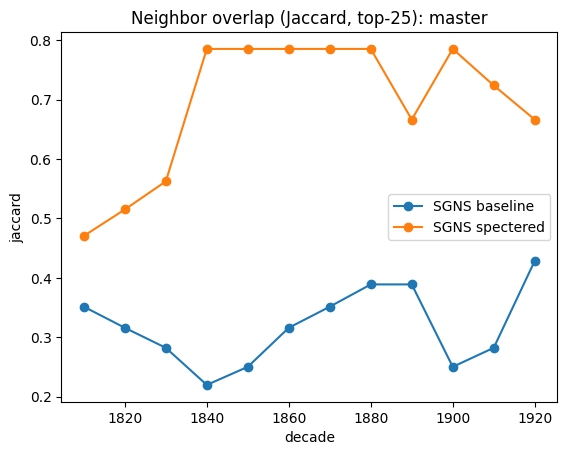

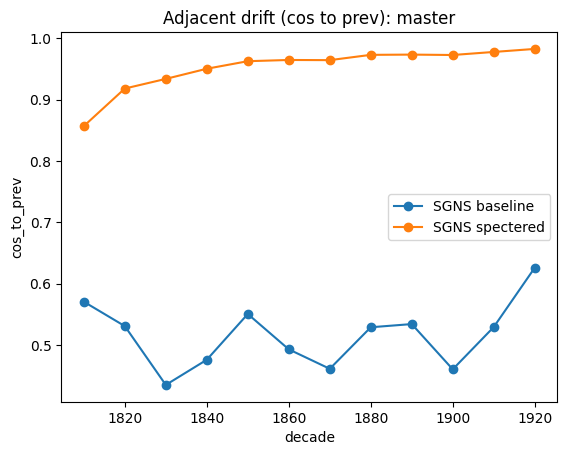


TERM: slave | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"negro, slaves, slavery, freeman, trade, african, abolition, traffic, galley, trader, captive, negroes"
1,1810,"slaves, negro, slavery, abolition, emancipation, african, trade, galley, oar, traffic, apprentice, vassal"
2,1820,"slaves, negro, slavery, trade, african, manumission, piracy, ethiopian, inhuman, contraband, servant, blacks"
3,1830,"slaves, slavery, negro, trade, african, piracy, mulatto, owner, abolition, freeman, emancipate, blacks"
4,1840,"slaves, slavery, negro, trade, african, holder, mulatto, holders, trader, traffic, abolition, labor"
5,1850,"slaves, negro, slavery, serf, trade, african, repression, piracy, manumission, recapture, negroes, mulatto"
6,1860,"slaves, negro, slavery, african, trade, negroes, fugitive, mulatto, trader, emancipated, slaveholders, blacks"
7,1870,"slaves, slavery, negro, trade, fugitive, african, mulatto, trader, negroes, piracy, serfs, emancipation"
8,1880,"slaves, negro, slavery, manumission, negroes, reopening, trade, fugitive, emancipation, serf, emancipated, african"
9,1890,"slaves, negro, slavery, fugitive, slaveholder, raiders, african, negroes, trade, runaway, reopening, emancipating"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"negro, slaves, slavery, freeman, trade, african, abolition, traffic, galley, trader, captive, negroes"
1,1810,"negro, slaves, slavery, african, trade, traffic, freeman, emancipation, apprentice, abolition, galley, captive"
2,1820,"slaves, negro, slavery, african, trade, freeman, traffic, captive, servitude, seaman, murderer, vile"
3,1830,"slaves, negro, slavery, african, freeman, trade, piracy, blacks, tyrant, mulatto, captive, contraband"
4,1840,"slaves, negro, slavery, trade, african, mulatto, freeman, piracy, blacks, alien, contraband, trader"
5,1850,"slaves, negro, slavery, trade, mulatto, african, piracy, freeman, serf, alien, trader, contraband"
6,1860,"slaves, negro, slavery, trade, mulatto, african, freeman, piracy, alien, trader, blacks, serf"
7,1870,"slaves, negro, slavery, mulatto, trade, african, trader, piracy, serf, emancipated, alien, freeman"
8,1880,"slaves, negro, slavery, mulatto, trade, serf, african, trader, emancipated, piracy, runaway, freeman"
9,1890,"slaves, negro, slavery, mulatto, runaway, african, trade, trader, negroes, slaveholders, serf, slaveholder"


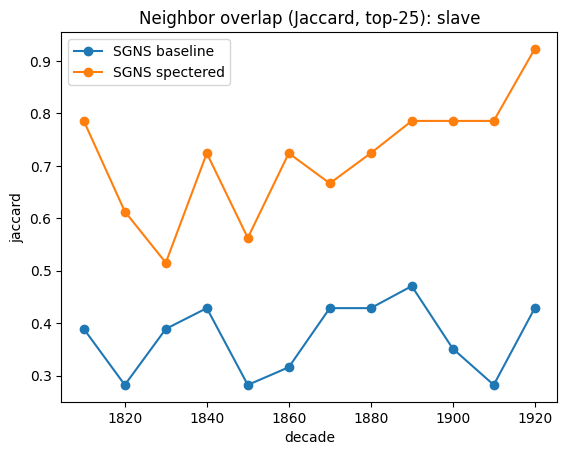

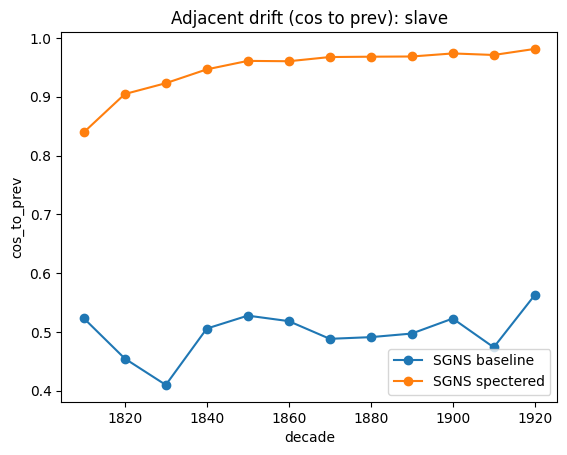


TERM: negro | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"slave, negroes, blacks, slaves, galley, african, indian, fur, seaman, freeman, pig, emancipation"
1,1810,"slave, negroes, slaves, darien, rio, indian, blacks, emancipation, african, congo, indians, gambia"
2,1820,"slave, negroes, blacks, rio, slaves, amazon, congo, orinoco, african, seaman, indian, elk"
3,1830,"negroes, slave, mulatto, slaves, slavery, african, blacks, africans, indian, whites, rio, colored"
4,1840,"slave, slaves, mulatto, negroes, indian, blacks, african, caucasian, slavery, malay, esquimaux, indians"
5,1850,"slave, slaves, negroes, intermarry, mulatto, blacks, african, mulattoes, woolly, caucasian, brazilian, serf"
6,1860,"slave, african, negroes, slaves, mulatto, slavery, blacks, colored, caucasian, status, race, races"
7,1870,"african, slaves, negroes, mulatto, slave, blacks, emancipation, slavery, indian, mongolian, mulattoes, kidnapped"
8,1880,"negroes, slave, african, slaves, slavery, mongolian, mulatto, blacks, race, chinaman, emancipation, intermarry"
9,1890,"negroes, slave, slaves, blacks, slavery, caucasian, mulatto, african, mulattoes, emancipation, status, colored"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"slave, negroes, blacks, slaves, galley, african, indian, fur, seaman, freeman, pig, emancipation"
1,1810,"negroes, slave, slaves, blacks, indian, african, darien, american, girl, whites, fur, freeman"
2,1820,"negroes, slave, blacks, slaves, indian, african, seaman, whites, american, darien, aborigines, indians"
3,1830,"negroes, slave, blacks, slaves, african, indian, mulatto, whites, american, amazon, africans, indians"
4,1840,"slave, negroes, mulatto, blacks, slaves, african, indian, caucasian, amazon, whites, slavery, malay"
5,1850,"slave, negroes, mulatto, blacks, slaves, african, intermarry, indian, caucasian, trader, africans, ethiopian"
6,1860,"slave, mulatto, negroes, african, blacks, slaves, intermarry, indian, caucasian, mulattoes, colored, trader"
7,1870,"mulatto, slave, negroes, african, blacks, slaves, indian, mulattoes, caucasian, trader, runaway, malay"
8,1880,"slave, mulatto, negroes, african, blacks, slaves, indian, mulattoes, mongolian, caucasian, runaway, slavery"
9,1890,"slave, negroes, mulatto, african, blacks, slaves, caucasian, mulattoes, indian, mongolian, slavery, runaway"


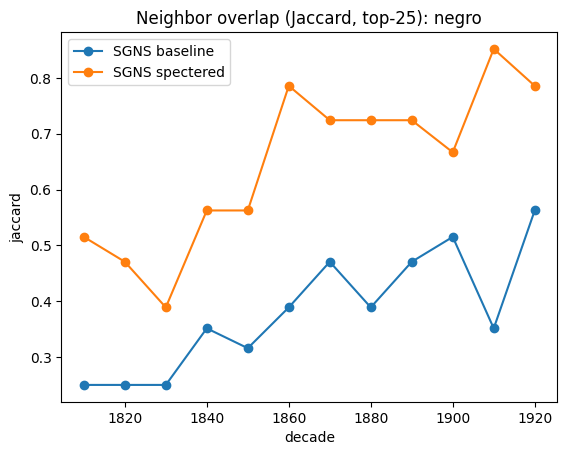

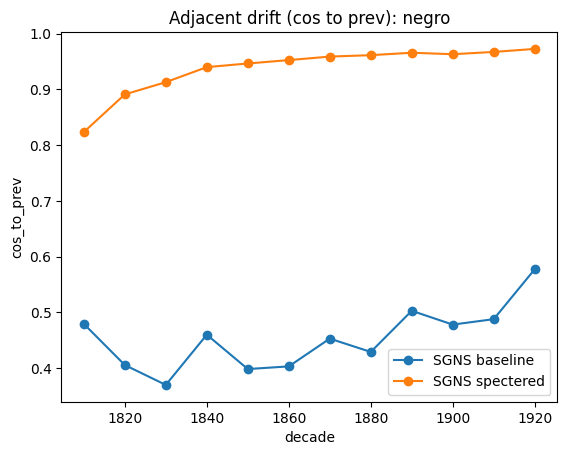


TERM: cotton | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"indigo, cloths, linen, silk, woollen, hemp, cloth, leather, flax, beans, tobacco, cocoa"
1,1810,"yarn, silk, hemp, linen, flax, stuffs, indigo, maize, woollen, cloths, wool, weaving"
2,1820,"woollen, yarn, silk, stuffs, bales, indigo, wool, manufactories, hemp, rice, sugar, linen"
3,1830,"silk, woollen, wool, manufacture, sugar, rice, hemp, manufactured, linen, manufactures, silks, indigo"
4,1840,"silk, woollen, wool, flax, sugar, indigo, manufactured, hemp, rice, linen, fabrics, silks"
5,1850,"wool, silk, beet, grower, hardware, flax, cottons, hemp, woollen, manufacture, sugar, indigo"
6,1860,"woolen, woollen, silk, hemp, wool, flax, rice, tobacco, indigo, linen, bales, manufactured"
7,1870,"woolen, silk, woollen, wool, rice, hemp, cottons, teas, flax, indigo, linen, manufacture"
8,1880,"jute, woollen, woolen, flax, wool, hemp, silk, rice, spinners, plugged, woollens, cottons"
9,1890,"wool, woollen, jute, silk, woolen, woollens, cacao, hemp, flax, fabrics, cutlery, tobacco"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"indigo, cloths, linen, silk, woollen, hemp, cloth, leather, flax, beans, tobacco, cocoa"
1,1810,"indigo, silk, hemp, cloths, linen, flax, woollen, wool, yarn, rice, cloth, beans"
2,1820,"indigo, silk, woollen, hemp, linen, yarn, cloths, stuffs, flax, rice, cloth, wool"
3,1830,"silk, indigo, woollen, wool, hemp, linen, flax, rice, stuffs, manufacture, sugar, yarn"
4,1840,"woollen, silk, wool, indigo, flax, hemp, linen, sugar, manufacture, yarn, cloth, cloths"
5,1850,"woollen, silk, wool, flax, indigo, hemp, yarn, rice, sugar, manufacture, linen, stuffs"
6,1860,"woollen, silk, hemp, wool, flax, indigo, cottons, rice, yarn, manufacture, linen, hardware"
7,1870,"silk, hemp, woollen, wool, woolen, flax, cottons, indigo, rice, yarn, manufacture, hardware"
8,1880,"woollen, hemp, woolen, wool, jute, silk, flax, cottons, rice, indigo, yarn, manufacture"
9,1890,"jute, woolen, woollen, wool, hemp, silk, flax, cottons, rice, woollens, yarn, tobacco"


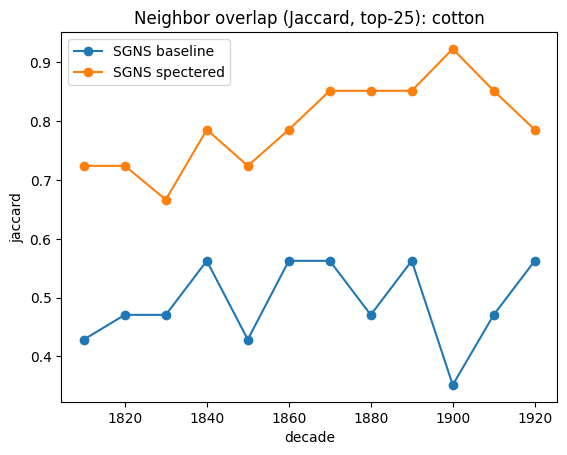

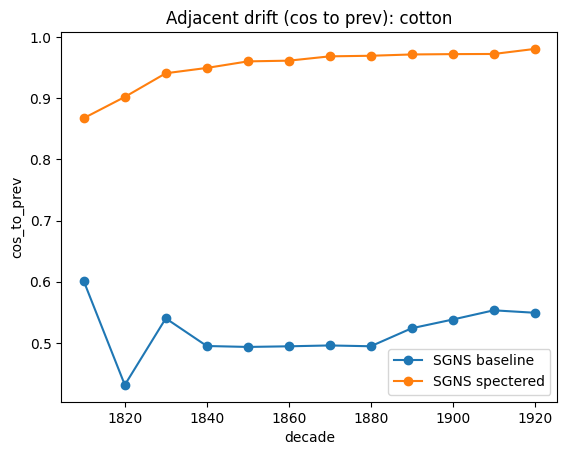


TERM: man | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"woman, creature, receiveth, fool, doeth, minded, natured, sinner, knoweth, honest, feels, hates"
1,1810,"woman, creature, idiot, clever, feareth, honest, person, receiveth, natured, virtuous, irishman, englishman"
2,1820,"trusteth, woman, feareth, neighbor, unblemished, asketh, soweth, receiveth, sirach, judgeth, soldier, whoso"
3,1830,"woman, creature, trusteth, receiveth, careth, feareth, judgest, lighteth, judgeth, believeth, seeth, god"
4,1840,"woman, young, judgest, fool, boy, gentleman, unblemished, citizen, soldier, committeth, knows, statesman"
5,1850,"woman, creature, men, trusteth, receiveth, young, gentleman, lighteth, judgeth, endued, gifted, beast"
6,1860,"woman, gentleman, virtuous, honest, citizen, statesman, elderly, young, lawyer, sinner, creature, girl"
7,1870,"woman, creature, brute, young, idiot, boy, knows, soldier, gentleman, who, girl, fool"
8,1880,"woman, trusteth, creature, person, knows, sinner, lighteth, esteems, prayeth, perfectibility, fool, delighteth"
9,1890,"woman, quickeneth, trusteth, sinner, creature, knoweth, principled, committeth, son, prayeth, loseth, liveth"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"woman, creature, receiveth, fool, doeth, minded, natured, sinner, knoweth, honest, feels, hates"
1,1810,"woman, creature, receiveth, honest, fool, knoweth, feareth, doeth, natured, person, virtuous, idiot"
2,1820,"woman, creature, receiveth, feareth, trusteth, knoweth, liar, fool, lad, doeth, englishman, minded"
3,1830,"woman, creature, feareth, receiveth, trusteth, liar, fool, knoweth, englishman, covetous, judgeth, doeth"
4,1840,"woman, creature, feareth, receiveth, fool, trusteth, knows, lad, doeth, judgest, soldier, judgeth"
5,1850,"woman, creature, feareth, trusteth, receiveth, lighteth, doeth, judgeth, knows, knoweth, fool, whoso"
6,1860,"woman, trusteth, creature, lighteth, receiveth, feareth, doeth, fool, englishman, judgeth, whoso, knows"
7,1870,"woman, creature, receiveth, lighteth, trusteth, feareth, boy, liar, brute, doeth, judgeth, knows"
8,1880,"woman, creature, trusteth, receiveth, lighteth, knows, liar, judgeth, brute, englishman, boy, lad"
9,1890,"woman, creature, trusteth, lighteth, receiveth, knows, feareth, englishman, judgeth, liar, boy, fool"


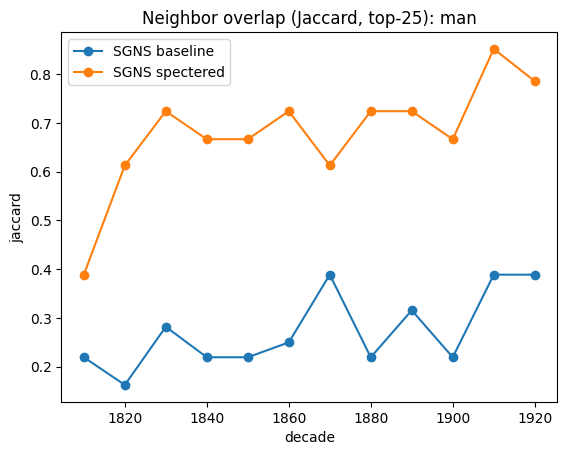

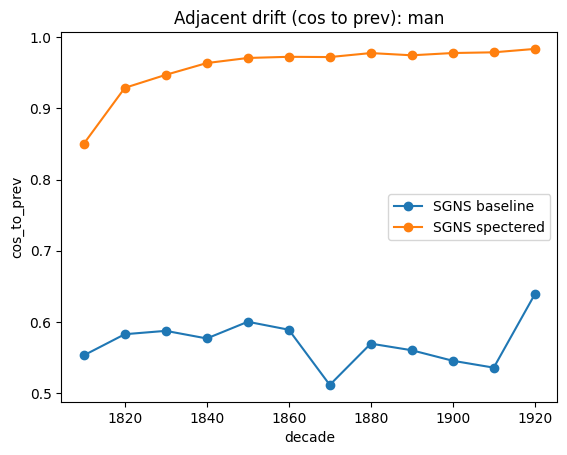


TERM: woman | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"girl, child, elderly, man, marries, gentlewoman, lady, boy, maid, spouse, young, wife"
1,1810,"girl, marries, child, elderly, man, wife, wench, young, lady, betrothed, maid, widow"
2,1820,"girl, young, wife, man, marries, child, elderly, husband, lady, mother, daughter, damsel"
3,1830,"child, girl, man, young, wife, she, marries, lady, boy, creature, mother, maid"
4,1840,"girl, man, young, child, wife, boy, lady, women, maiden, she, married, elderly"
5,1850,"girl, child, man, boy, wife, lady, baby, jezebel, teens, maid, mother, she"
6,1860,"girl, man, child, wife, maid, young, she, baby, maiden, mother, lady, husband"
7,1870,"girl, man, child, she, wife, lady, young, maid, elderly, maiden, marries, married"
8,1880,"man, girl, child, young, husband, she, baby, wife, committeth, mother, lady, married"
9,1890,"man, girl, child, young, she, maid, wife, married, husband, women, maiden, elderly"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"girl, child, elderly, man, marries, gentlewoman, lady, boy, maid, spouse, young, wife"
1,1810,"girl, child, man, elderly, marries, wife, maid, gentlewoman, young, lady, boy, maiden"
2,1820,"girl, man, child, marries, elderly, wife, young, gentlewoman, lady, maiden, husband, maid"
3,1830,"girl, child, man, marries, young, maiden, elderly, wife, maid, lady, gentlewoman, boy"
4,1840,"girl, man, child, young, maiden, marries, elderly, maid, wife, boy, gentlewoman, lady"
5,1850,"girl, child, man, maiden, boy, elderly, young, wife, marries, gentlewoman, lady, maid"
6,1860,"girl, child, man, boy, elderly, maiden, wife, young, lady, she, marries, gentlewoman"
7,1870,"girl, man, child, boy, elderly, wife, young, maiden, maid, lady, she, idiot"
8,1880,"girl, man, child, boy, maiden, young, wife, gentlewoman, she, elderly, baby, maid"
9,1890,"girl, man, child, boy, maiden, young, maid, wife, baby, gentlewoman, she, elderly"


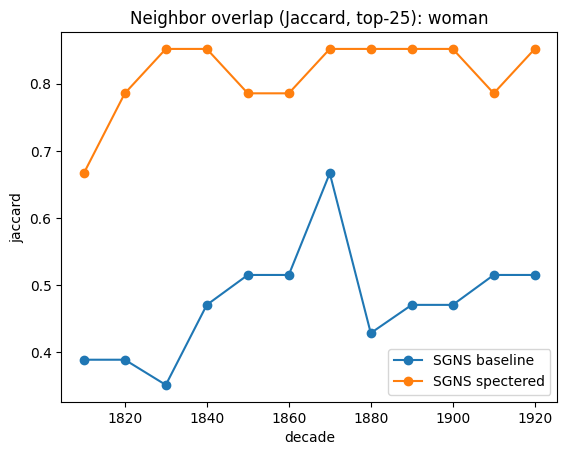

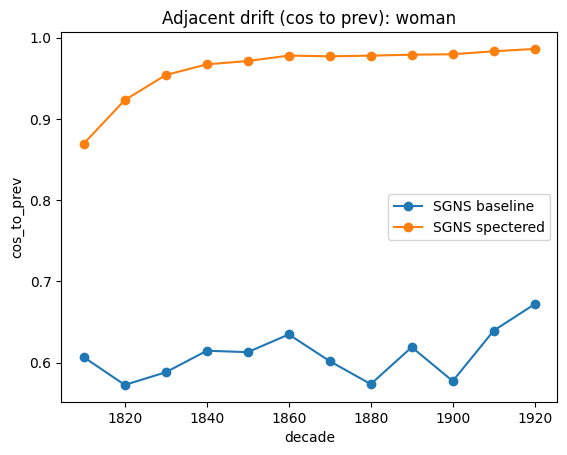


TERM: child | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"girl, woman, children, mother, infant, wife, womb, marries, boy, nurse, spouse, educate"
1,1810,"mother, girl, children, infant, woman, wife, marries, boy, son, daughter, betrothed, parent"
2,1820,"children, girl, boy, infant, wife, woman, mother, husband, babe, pitieth, parents, inlaw"
3,1830,"infant, woman, mother, children, wife, boy, girl, babe, husband, parent, baby, weaned"
4,1840,"infant, girl, children, boy, mother, woman, wife, nurse, suckling, sister, daughter, parent"
5,1850,"mother, boy, woman, girl, infant, baby, children, wife, suckling, husband, nurse, daughter"
6,1860,"mother, girl, boy, infant, baby, children, woman, wife, youngest, nurse, babe, son"
7,1870,"baby, infant, mother, boy, girl, babe, woman, children, nurse, wife, she, foetus"
8,1880,"infant, baby, grandchild, mother, girl, boy, babe, woman, children, nurse, bom, birth"
9,1890,"boy, baby, infant, girl, mother, newborn, children, babe, woman, nurse, wife, husband"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"girl, woman, children, mother, infant, wife, womb, marries, boy, nurse, spouse, educate"
1,1810,"mother, girl, infant, woman, children, wife, womb, marries, boy, husband, son, nurse"
2,1820,"mother, infant, girl, children, woman, wife, boy, husband, womb, babe, son, marries"
3,1830,"infant, mother, woman, girl, wife, children, boy, babe, husband, womb, son, she"
4,1840,"infant, mother, woman, girl, children, wife, babe, boy, husband, nurse, womb, weaned"
5,1850,"infant, mother, woman, girl, boy, children, wife, babe, baby, nurse, husband, weaned"
6,1860,"infant, mother, woman, girl, boy, baby, children, babe, wife, nurse, weaned, husband"
7,1870,"mother, infant, woman, girl, baby, boy, babe, children, wife, nurse, weaned, husband"
8,1880,"infant, mother, girl, baby, woman, boy, babe, children, nurse, wife, grandchild, husband"
9,1890,"infant, baby, mother, girl, woman, boy, babe, children, nurse, wife, grandchild, husband"


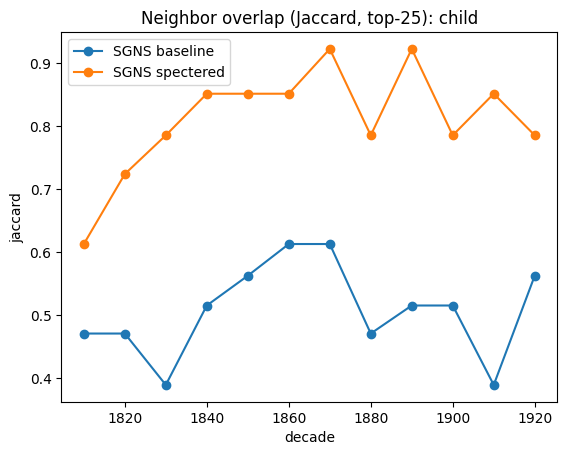

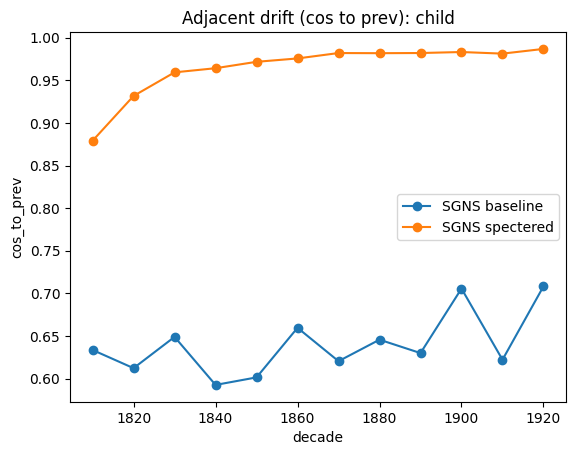


TERM: house | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"mansion, houses, commons, journals, hotel, barn, lords, dwelling, coffee, tabernacle, stables, door"
1,1810,"commons, houses, committee, parsonage, lords, mansion, dining, lodge, tellers, room, chelsea, farm"
2,1820,"houses, commons, lobby, parsonage, holyrood, mansion, lords, lodge, farm, palace, family, adjourn"
3,1830,"carlton, houses, commons, hotel, lodge, shop, dwelling, hall, parsonage, mansion, barn, farm"
4,1840,"commons, houses, mansion, grosvenor, lodge, lords, parlour, dwelling, palace, farm, dining, apartment"
5,1850,"commons, houses, mansion, carlton, charnel, verandah, lords, hotel, bloomsbury, rooms, dining, barn"
6,1860,"houses, commons, barn, mansion, dwelling, room, carlton, rooms, cottage, palace, hotel, bedroom"
7,1870,"mansion, houses, commons, carlton, dwelling, tavern, barn, garden, hotel, palace, door, hall"
8,1880,"commons, drawingroom, houses, cottage, palace, barn, culpeper, mansion, door, dwelling, lobby, lodging"
9,1890,"commons, roomed, houses, adjoined, culpeper, dwelling, rooms, aldersgate, mansion, barn, cottage, palace"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"mansion, houses, commons, journals, hotel, barn, lords, dwelling, coffee, tabernacle, stables, door"
1,1810,"houses, commons, mansion, lords, dining, parsonage, committee, hotel, lodgings, lodge, barn, door"
2,1820,"houses, parsonage, mansion, commons, holyrood, lodge, lobby, lodgings, lords, palace, hall, hotel"
3,1830,"houses, carlton, lodge, parsonage, commons, mansion, holyrood, lobby, hall, hotel, chamber, barn"
4,1840,"houses, lodge, carlton, parsonage, holyrood, commons, mansion, lobby, hall, hotel, chamber, palace"
5,1850,"houses, mansion, parsonage, carlton, commons, hotel, holyrood, lodge, lobby, hall, palace, chamber"
6,1860,"houses, mansion, carlton, parsonage, lobby, commons, hotel, lodge, barn, palace, chamber, hall"
7,1870,"mansion, houses, carlton, parsonage, hotel, lobby, palace, commons, hall, chamber, lodgings, barn"
8,1880,"houses, mansion, carlton, lobby, palace, parsonage, drawingroom, barn, hall, commons, cottage, hotel"
9,1890,"mansion, houses, carlton, drawingroom, lobby, parsonage, hall, commons, palace, cottage, parlour, lodgings"


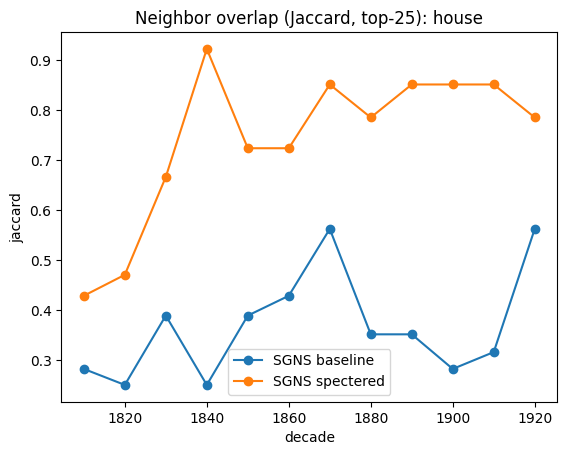

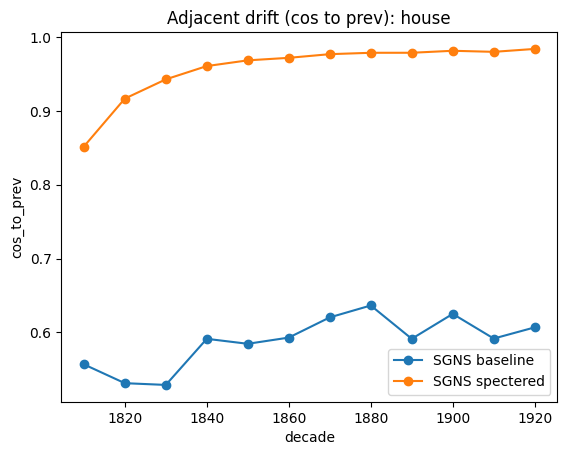


TERM: room | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"parlour, dining, apartment, rooms, kitchen, chimney, apartments, stairs, ceiling, hall, gallery, chamber"
1,1810,"apartment, rooms, dining, parlour, kitchen, apartments, chamber, door, gallery, stairs, hall, sofa"
2,1820,"apartment, dining, parlour, rooms, kitchen, saloon, door, floor, window, corridor, apartments, chamber"
3,1830,"rooms, apartment, dining, parlour, kitchen, door, chamber, saloon, window, cabin, bedroom, hall"
4,1840,"apartment, rooms, shutter, dining, parlour, kitchen, door, billiard, window, parlor, bedroom, apartments"
5,1850,"rooms, dining, apartment, kitchen, parlour, parlor, bedroom, ajar, window, fireplace, chamber, verandah"
6,1860,"dining, rooms, apartment, bedroom, parlour, kitchen, parlor, door, upstairs, window, apartments, hall"
7,1870,"bedroom, dining, apartment, rooms, kitchen, parlor, parlour, door, saloon, window, upstairs, doorway"
8,1880,"dining, drawingroom, rooms, bedroom, apartment, parlor, upstairs, parlour, kitchen, fireplace, window, hall"
9,1890,"dining, apartment, rooms, bedroom, parlor, kitchen, parlour, upstairs, door, window, corridor, hall"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"parlour, dining, apartment, rooms, kitchen, chimney, apartments, stairs, ceiling, hall, gallery, chamber"
1,1810,"parlour, dining, apartment, rooms, kitchen, hall, apartments, gallery, chamber, stairs, chimney, door"
2,1820,"parlour, dining, apartment, rooms, kitchen, cabin, chamber, apartments, window, door, hall, gallery"
3,1830,"parlour, apartment, dining, rooms, kitchen, chamber, door, window, cabin, hall, apartments, saloon"
4,1840,"parlour, apartment, dining, rooms, kitchen, door, window, cabin, saloon, chamber, apartments, shutter"
5,1850,"parlour, apartment, rooms, dining, kitchen, window, door, bedroom, cabin, chamber, saloon, parlor"
6,1860,"parlour, dining, apartment, rooms, bedroom, kitchen, parlor, door, window, cabin, saloon, shutter"
7,1870,"dining, bedroom, parlour, apartment, rooms, kitchen, parlor, window, door, saloon, cabin, upstairs"
8,1880,"bedroom, dining, apartment, parlour, parlor, rooms, drawingroom, kitchen, upstairs, window, door, saloon"
9,1890,"bedroom, dining, parlour, apartment, parlor, rooms, kitchen, drawingroom, upstairs, window, saloon, door"


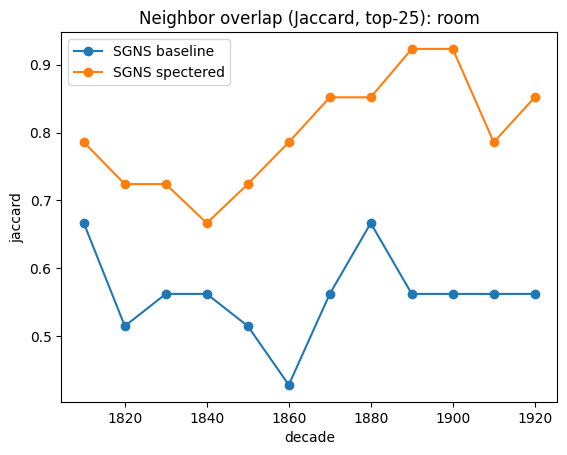

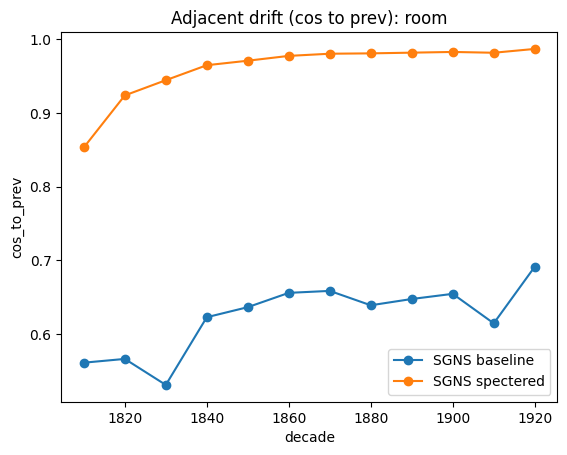


TERM: work | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"edition, volume, materials, finished, works, editions, worked, poem, translation, voluminous, prefixed, quarto"
1,1810,"works, publication, edition, finished, working, essay, treatise, volume, materials, editions, plan, task"
2,1820,"works, edition, author, finished, labours, compilation, poem, unfinished, wrought, translation, materials, working"
3,1830,"works, supererogation, compilation, labours, edition, volume, working, finished, volumes, poem, preface, publication"
4,1840,"works, treatise, edition, finish, publication, volume, wicker, translation, compilation, author, dedicate, task"
5,1850,"labour, works, compiling, working, edition, completion, labor, finished, undertaking, republication, enhances, finish"
6,1860,"finish, task, works, worked, accomplish, supererogation, completion, accomplished, done, working, editing, labour"
7,1870,"task, devote, labor, worked, finished, working, labours, finish, accomplished, completed, done, editing"
8,1880,"finish, task, labors, evangelization, labours, working, done, worked, works, labour, compilation, finished"
9,1890,"working, done, organising, task, works, undertaken, finish, undertake, finished, editing, worker, machinist"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"edition, volume, materials, finished, works, editions, worked, poem, translation, voluminous, prefixed, quarto"
1,1810,"works, finished, edition, materials, publication, translation, finish, volume, task, supplement, editions, treatise"
2,1820,"works, edition, finished, translation, materials, accomplish, finish, poem, volume, labours, supplement, editions"
3,1830,"works, edition, finished, finish, materials, compilation, labours, translation, poem, volume, supplement, book"
4,1840,"works, finished, finish, edition, compilation, treatise, translation, labours, dedicate, materials, book, volume"
5,1850,"works, compilation, finished, edition, finish, materials, labours, book, volume, supererogation, author, treatise"
6,1860,"works, supererogation, finish, finished, compilation, materials, task, book, accomplish, completion, working, volume"
7,1870,"finish, works, finished, supererogation, task, compilation, working, accomplish, labours, materials, completion, worked"
8,1880,"finish, finished, works, supererogation, task, compilation, labours, working, worked, editing, completion, dedicate"
9,1890,"finish, working, works, finished, supererogation, task, editing, labours, compilation, worked, book, completion"


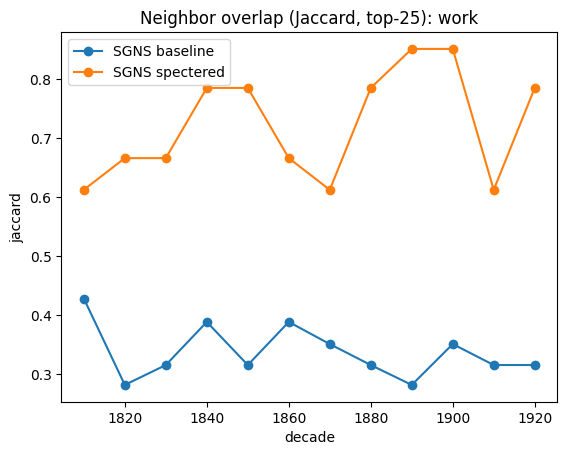

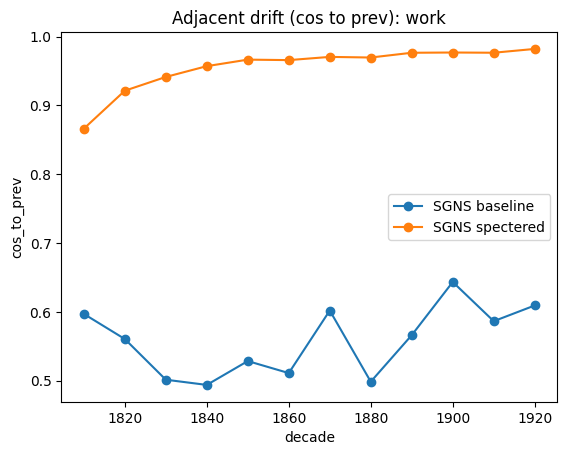


TERM: money | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"sums, cash, lending, specie, monies, funds, sum, defray, expended, appropriation, securities, coffers"
1,1810,"sums, sum, repayment, monies, funds, cash, purchase, specie, premium, pounds, dividends, securities"
2,1820,"sums, sum, moneys, payment, funds, monies, specie, pounds, deducted, amount, loan, defray"
3,1830,"sums, sum, funds, cash, purchase, payment, specie, amount, repayment, defray, loan, surplus"
4,1840,"sums, sum, cash, purchase, funds, moneys, disbursement, pay, payment, assignats, loan, remittance"
5,1850,"sums, cash, disbursed, discounted, expending, moneys, sum, reimbursed, redeemable, funds, buy, purchase"
6,1860,"sums, cash, sum, moneys, purchase, loaned, buy, funds, loan, paid, payment, pay"
7,1870,"sums, cash, moneys, sum, funds, coin, buy, pay, loans, loan, currency, paid"
8,1880,"sums, cash, moneys, reimbursement, disposable, funds, sum, pay, paid, coin, pocketed, embezzled"
9,1890,"sums, cash, dollars, purchase, pay, funds, sum, moneys, amount, payment, purchasing, coin"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"sums, cash, lending, specie, monies, funds, sum, defray, expended, appropriation, securities, coffers"
1,1810,"sums, cash, monies, specie, lending, sum, funds, defray, deducted, purchasing, purchase, loan"
2,1820,"sums, cash, sum, specie, monies, funds, moneys, deducted, defray, loan, expended, purchase"
3,1830,"sums, cash, sum, specie, funds, monies, purchase, loan, defray, expended, moneys, amount"
4,1840,"sums, cash, funds, specie, sum, purchase, monies, loan, purchases, moneys, expended, amount"
5,1850,"cash, sums, funds, purchase, moneys, specie, monies, sum, loan, purchases, expended, repayment"
6,1860,"cash, sums, purchase, monies, funds, moneys, specie, purchases, loan, sum, pay, repayment"
7,1870,"cash, sums, purchase, funds, moneys, purchases, monies, loan, pay, sum, specie, buy"
8,1880,"cash, sums, purchase, funds, moneys, purchases, pay, monies, sum, buy, loan, coin"
9,1890,"cash, sums, purchase, funds, loaned, purchases, pay, moneys, monies, purchasing, refund, specie"


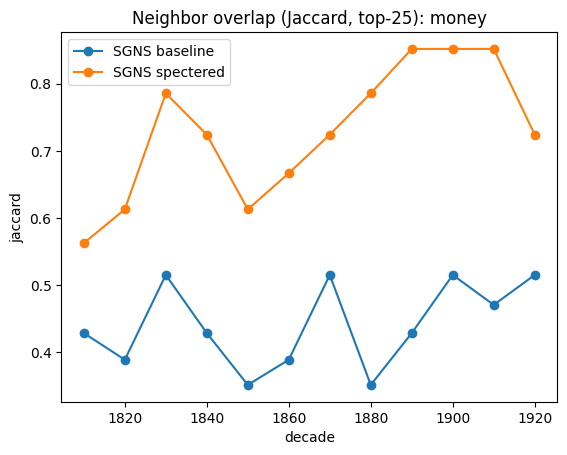

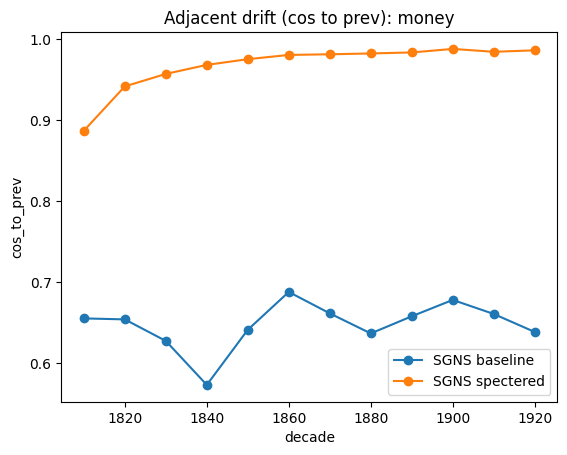


TERM: horse | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"rider, mule, dragoons, troop, alighted, spurs, saddle, dismounted, horsemen, ass, horses, shoe"
1,1810,"mule, horses, gallop, saddle, cavalry, horsemen, alighted, waggon, mounted, horseman, dismounted, troop"
2,1820,"saddled, cavalry, dragoons, horses, hoof, steed, mounted, mule, spurred, horsemen, charger, dismount"
3,1830,"horses, troop, steed, saddle, racing, horsemen, cavalry, galloped, rode, saddled, charger, mule"
4,1840,"horses, dismounting, saddle, steed, alighting, gig, mounted, dragoon, mules, cavalry, dismounted, harnessed"
5,1850,"horses, cavalry, reined, bridled, steed, saddle, dismounting, dismounted, hobby, grenadier, rider, nag"
6,1860,"horses, pony, dog, steed, mule, dismounting, saddle, ass, cart, bridle, mare, reined"
7,1870,"horses, steed, pony, mule, dismounted, donkey, cavalry, rider, mules, hobby, driver, cart"
8,1880,"horses, dismounting, mule, hitched, fleetest, pony, steed, dismounted, saddle, rider, gallop, cart"
9,1890,"horses, remounted, steed, pony, crupper, mule, gelding, picketed, saddle, dismounted, cart, sleigh"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"rider, mule, dragoons, troop, alighted, spurs, saddle, dismounted, horsemen, ass, horses, shoe"
1,1810,"mule, troop, saddle, dragoons, horses, rider, alighted, horsemen, dismounted, gallop, cavalry, ass"
2,1820,"mule, dragoons, horses, troop, saddle, horsemen, rider, cavalry, mounted, alighted, dismounted, cart"
3,1830,"mule, horses, troop, saddle, dragoons, horsemen, rider, dismounted, mounted, steed, cavalry, alighted"
4,1840,"horses, mule, saddle, steed, mounted, troop, rider, dismounted, dragoons, dismounting, cart, gallop"
5,1850,"horses, mule, steed, saddle, mounted, dismounted, rider, dismounting, pony, troop, cavalry, saddled"
6,1860,"horses, mule, pony, steed, saddle, dismounting, dismounted, mounted, saddled, team, rider, cart"
7,1870,"horses, mule, steed, pony, saddle, dismounting, dismounted, mounted, team, cart, rider, saddled"
8,1880,"horses, pony, mule, steed, dismounting, rider, team, saddle, dismounted, cart, hitched, donkey"
9,1890,"horses, pony, mule, steed, dismounting, cart, saddle, rider, donkey, dismounted, team, wagon"


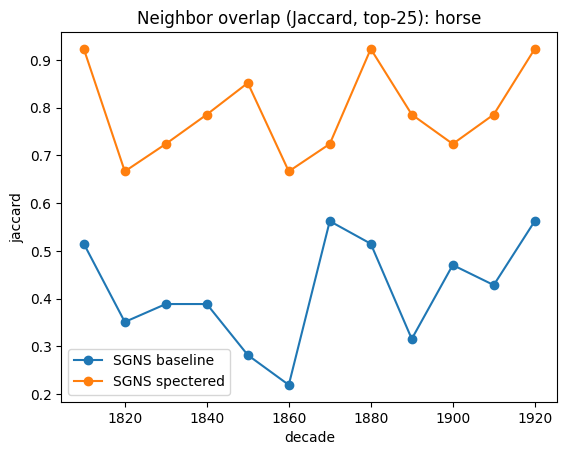

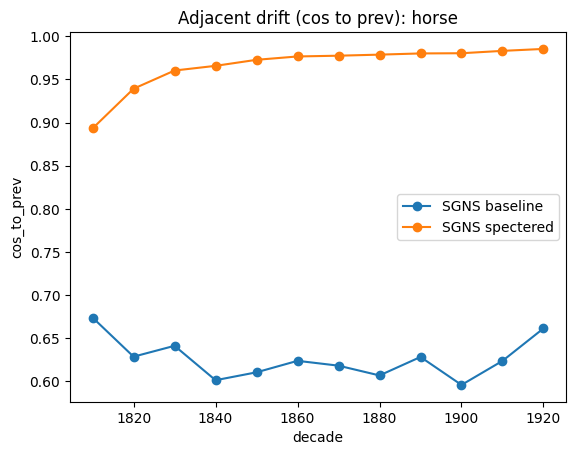


TERM: gay | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"sprightly, gaiety, dresses, jollity, amorous, comic, witty, banquet, airs, sweetest, pensive, giddy"
1,1810,"humoured, flutter, sprightly, joyous, giddy, blooming, youthful, placid, airy, thoughtless, flowery, melodious"
2,1820,"gayest, humorous, drest, playful, fashionable, fun, jovial, brocade, prattle, fascinating, voluptuous, witty"
3,1830,"gayest, joyous, sombre, sprightly, merry, gaudy, jovial, gaiety, voluptuous, witty, gorgeous, thoughtless"
4,1840,"gayest, showy, flowery, voluptuous, gallants, masquerade, gaiety, graceful, ringlets, variegated, revel, shabby"
5,1850,"flaunting, streamers, gayly, tasteful, voluptuous, pennons, pavilions, thoughtless, saloons, gaiety, sprightly, joyous"
6,1860,"streamers, gayest, sprightly, cheerful, merry, gayly, graceful, jovial, sported, joyous, flaunting, russet"
7,1870,"gaiety, dresses, joyous, gayest, cheerful, merry, showy, lussac, gayly, festal, jovial, attire"
8,1880,"lussac, lightsome, joyous, brilliant, gorgeous, merry, mirth, andalusian, sunshiny, drest, jocund, gayer"
9,1890,"joyous, bedecked, cheerful, gondolier, gayety, bedizened, gayest, lothario, gorgeous, gondolas, graceful, satins"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"sprightly, gaiety, dresses, jollity, amorous, comic, witty, banquet, airs, sweetest, pensive, giddy"
1,1810,"sprightly, gaiety, jollity, humoured, youthful, mirth, blooming, merry, giddy, witty, amorous, flutter"
2,1820,"sprightly, gayest, gaiety, humoured, merry, witty, blooming, drest, flutter, cheerful, humorous, sweetest"
3,1830,"gayest, sprightly, gaiety, merry, joyous, sombre, witty, thoughtless, jovial, humoured, gaudy, flowery"
4,1840,"gayest, sprightly, gaiety, joyous, witty, voluptuous, jovial, merry, gaudy, masquerade, airy, mirth"
5,1850,"gayest, sprightly, gaiety, joyous, voluptuous, revel, masquerade, gaudy, jovial, witty, merry, thoughtless"
6,1860,"gayest, sprightly, joyous, jovial, gaiety, voluptuous, revel, merry, cheerful, thoughtless, blooming, gaudy"
7,1870,"gayest, sprightly, gaiety, jovial, joyous, showy, gaudy, revel, merry, playful, gaily, gayly"
8,1880,"gayest, sprightly, joyous, gaudy, jovial, merry, masquerade, revel, gaiety, drest, gayly, gorgeous"
9,1890,"gayest, joyous, sprightly, masquerade, merry, gaudy, gayety, gaiety, jovial, cheerful, lightsome, revel"


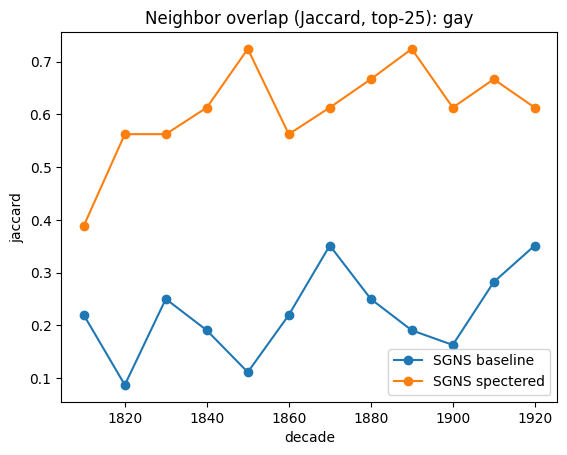

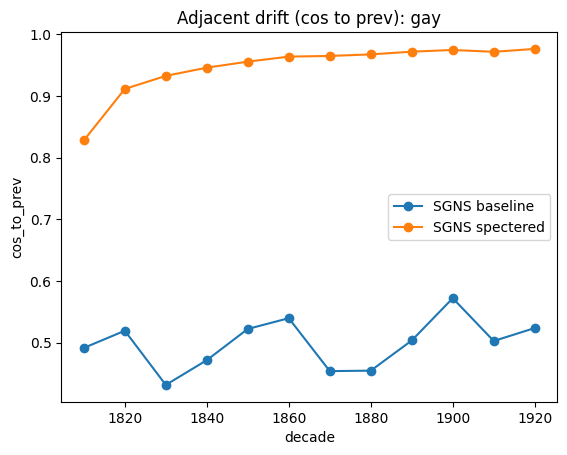


TERM: broadcast | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
1,1810,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
2,1820,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
3,1830,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
4,1840,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
5,1850,"drills, sown, sows, sowing, scatter, sow, seed, sowed, germinate, seeds, ploughed, tilling"
6,1860,"sown, drills, scattered, sowed, scatter, sowing, overspread, disseminated, spread, undergrowth, thistles, seed"
7,1870,"sown, sowing, sowed, drills, scattered, over, thistles, scatter, seeds, strewn, greedily, sow"
8,1880,"scattered, sown, scatter, seed, sows, wildfire, thinly, sowed, scattering, spread, spreading, dispersed"
9,1890,"scattered, sowing, thickly, sown, sowed, sorting, scatter, biennial, spread, unimproved, thinly, strewn"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
1,1810,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
2,1820,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
3,1830,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
4,1840,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
5,1850,"sown, drills, sows, sowed, sowing, sow, ploughed, scatter, harvests, germinate, seed, wheat"
6,1860,"sown, drills, scatter, sowed, ploughed, sowing, spread, overspread, scattered, harvests, sow, thistles"
7,1870,"sown, sowed, scatter, scattered, drills, sowing, spread, harvests, thistles, ploughed, sow, seeds"
8,1880,"scatter, scattered, spread, sown, harvests, sowed, thinly, sowing, sow, sows, ploughed, fields"
9,1890,"scattered, scatter, sowed, spread, sown, sowing, ploughed, thinly, spreading, sow, harvests, tilled"


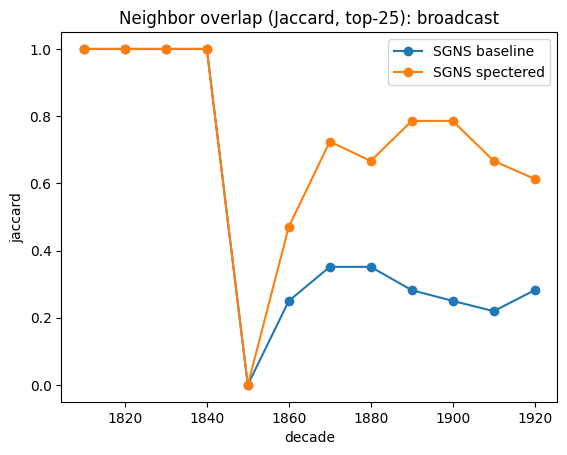

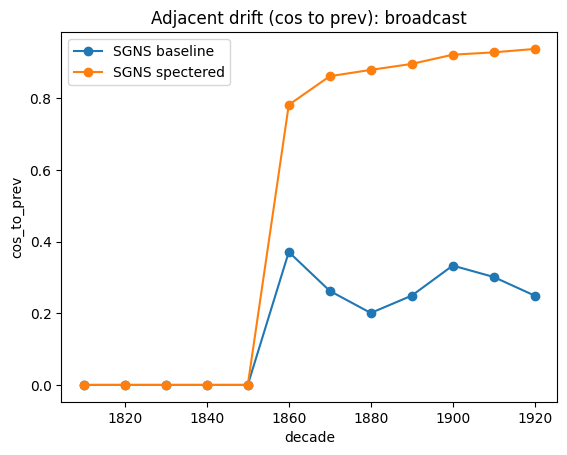


TERM: radio | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
1,1810,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
2,1820,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
3,1830,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
4,1840,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
5,1850,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
6,1860,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
7,1870,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
8,1880,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
9,1890,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
1,1810,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
2,1820,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
3,1830,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
4,1840,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
5,1850,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
6,1860,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
7,1870,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
8,1880,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
9,1890,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"


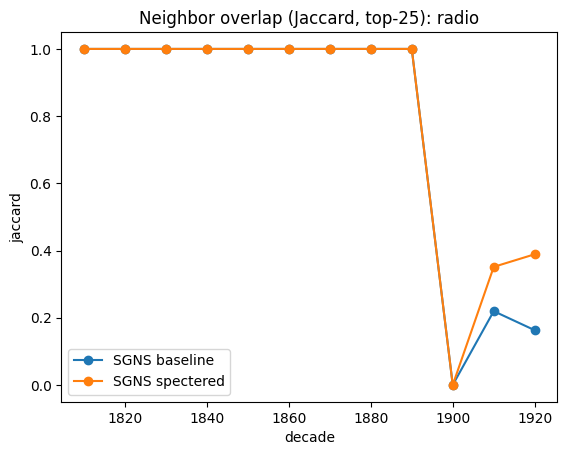

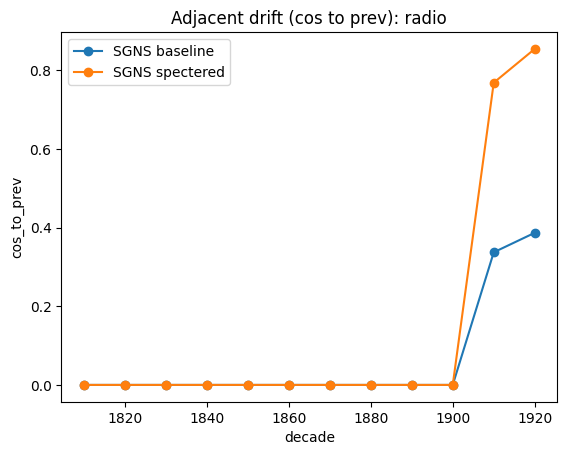


TERM: wireless | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
1,1810,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
2,1820,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
3,1830,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
4,1840,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
5,1850,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
6,1860,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
7,1870,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
8,1880,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
9,1890,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
1,1810,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
2,1820,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
3,1830,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
4,1840,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
5,1850,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
6,1860,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
7,1870,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
8,1880,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
9,1890,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"


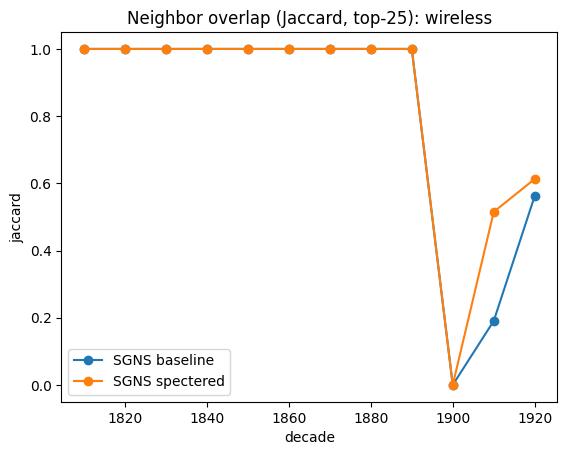

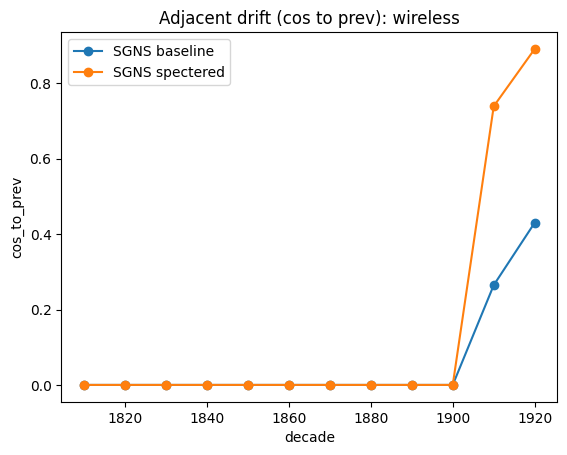


TERM: telegraph | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
1,1810,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
2,1820,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
3,1830,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
4,1840,"electro, railroad, electric, observatory, intelligencer, united, overland, exploring, cashier, wires, clark, lancet"
5,1850,"railroad, morse, electric, railway, locomotives, railways, railroads, fulton, patented, steam, hydraulic, wires"
6,1860,"telegraphic, electric, railroad, telegraphs, railway, railroads, railways, cable, atlantic, wires, communication, steam"
7,1870,"electric, railroad, russo, wires, railroads, telegraphic, telegraphy, railway, steamship, telegraphs, magnetic, morse"
8,1880,"railroad, telephone, railroads, electric, railway, tramway, telegraphs, telegraphic, cable, railways, wires, ferries"
9,1890,"telephone, railroad, railway, steamship, electric, cable, railways, railroads, postal, telegraphic, wires, pointers"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
1,1810,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
2,1820,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
3,1830,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
4,1840,"electro, steam, cashier, railroad, gazette, intelligencer, watt, overland, editor, incorporating, voltaic, revising"
5,1850,"morse, railroad, steam, railway, railroads, railways, electro, electric, fulton, watt, engineer, patented"
6,1860,"railroad, morse, railroads, railway, railways, telegraphic, telegraphs, steam, electric, electro, electrical, fulton"
7,1870,"railroad, telegraphic, railroads, railway, railways, telegraphs, morse, electric, steamship, steam, electrical, electro"
8,1880,"telegraphic, railroad, railroads, railway, telegraphs, railways, telephone, electric, tramway, morse, steamship, overland"
9,1890,"telephone, telegraphic, railroad, railroads, railway, telegraphs, electric, railways, steamship, postal, morse, overland"


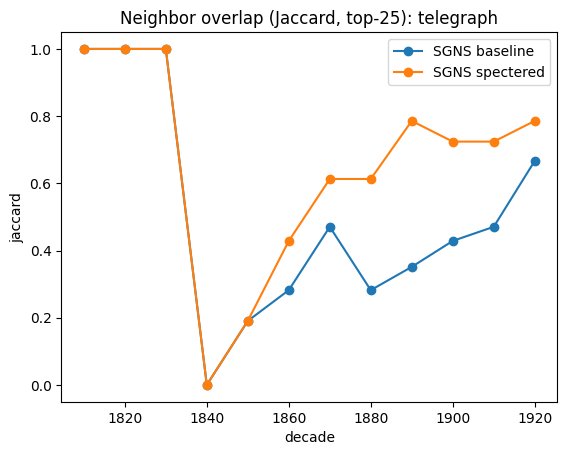

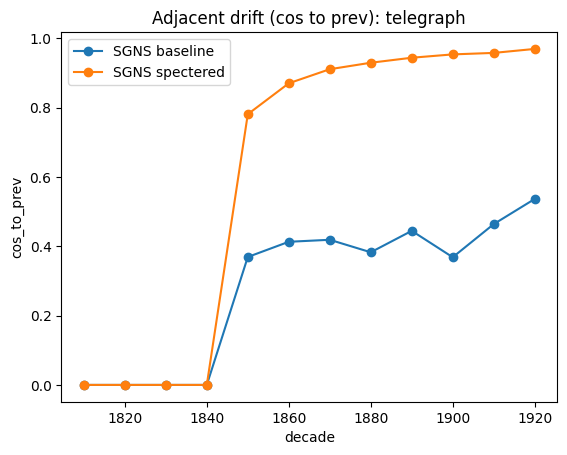


TERM: telephone | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
1,1810,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
2,1820,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
3,1830,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
4,1840,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
5,1850,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
6,1860,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
7,1870,"electrical, cilia, tick, electro, telegraph, wires, electric, armature, drum, bell, pivot, humming"
8,1880,"microphone, telegraph, electric, motors, wires, dynamo, magneto, generator, tramway, railroad, telegraphs, steamship"
9,1890,"telegraph, electric, railroad, wires, railway, edison, steamship, phonograph, westinghouse, railroads, company, lighting"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
1,1810,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
2,1820,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
3,1830,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
4,1840,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
5,1850,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
6,1860,"halite, avast, lites, keelson, geschichtlichen, sparred, dalriada, insurrectionists, manta, fifield, gamelin, waitaki"
7,1870,"armature, electrical, voltaic, percussion, electro, bell, magnet, magnetism, electric, drum, telegraph, tick"
8,1880,"microphone, telegraph, electric, motors, magneto, wires, voltaic, electrical, galvanic, bellows, wire, thermo"
9,1890,"telegraph, microphone, electric, wires, electrical, voltaic, galvanic, magneto, motors, telegraphic, steamship, tramway"


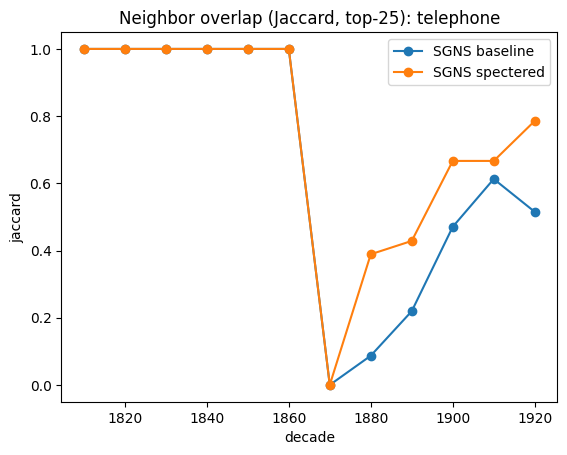

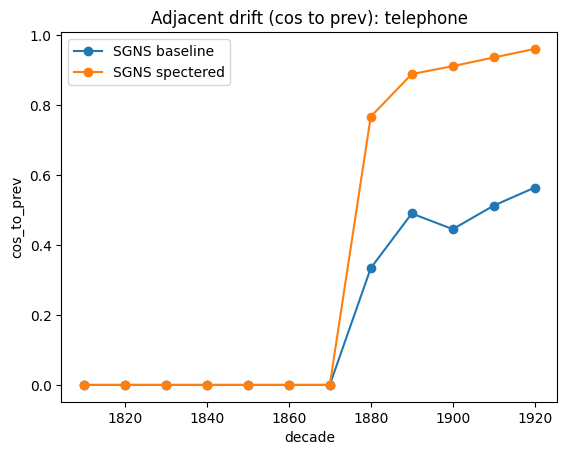


TERM: awful | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"tremendous, pensive, majestic, awe, solemnity, gloomy, dreadful, impressive, stillness, lifts, solemn, nod"
1,1810,"dreadful, impressive, stillness, terrible, sublime, tremendous, gloomy, solemn, sanctions, rending, majestic, solemnity"
2,1820,"appalling, solemn, dreadful, terrific, impressive, scene, stillness, majestic, terrible, presentiment, solitudes, solemnity"
3,1830,"dreadful, terrible, tremendous, solemn, fearful, inexpressibly, momentous, mysterious, sublime, terrific, appalling, impending"
4,1840,"appalling, terrible, dreadful, fearful, tremendous, solemn, terrific, impressive, mysterious, sublime, dismal, frightful"
5,1850,"dreadful, awfully, terrible, fearful, solemn, tremendous, terrific, solemnity, sublime, terrors, appalling, impending"
6,1860,"dreadful, terrible, fearful, frightful, terrific, horrible, tremendous, solemnity, horrid, solemn, appalling, contemplate"
7,1870,"terrible, dreadful, fearful, solemn, impressive, appalling, mournful, mysterious, tremendous, sublime, sad, stillness"
8,1880,"dreadful, frightful, terrible, horrible, awfulness, fearful, appalling, mournful, solemn, stillness, ominous, portent"
9,1890,"indescribably, dreadful, terrible, solemn, impressive, tremendous, fearful, sublime, awfulness, horrible, solemnity, sad"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"tremendous, pensive, majestic, awe, solemnity, gloomy, dreadful, impressive, stillness, lifts, solemn, nod"
1,1810,"dreadful, tremendous, gloomy, impressive, stillness, solemn, solemnity, majestic, awaited, mournful, spectacle, gloom"
2,1820,"dreadful, impressive, solemn, tremendous, stillness, horrid, majestic, gloomy, appalling, spectacle, terrible, mysterious"
3,1830,"dreadful, solemn, tremendous, terrible, appalling, mysterious, impressive, gloomy, stillness, majestic, fearful, horrid"
4,1840,"dreadful, appalling, tremendous, solemn, terrible, fearful, mysterious, impressive, terrific, stillness, mournful, sad"
5,1850,"dreadful, appalling, terrible, tremendous, solemn, awfully, fearful, mysterious, terrific, stillness, terrors, sad"
6,1860,"dreadful, appalling, terrible, fearful, terrific, tremendous, solemn, awfully, mysterious, frightful, mournful, stillness"
7,1870,"dreadful, appalling, terrible, fearful, terrific, tremendous, solemn, mysterious, frightful, mournful, stillness, portentous"
8,1880,"dreadful, appalling, fearful, terrible, mournful, frightful, mysterious, solemn, tremendous, stillness, ominous, terrific"
9,1890,"dreadful, appalling, fearful, terrible, mysterious, solemn, frightful, awfulness, mournful, stillness, tremendous, ominous"


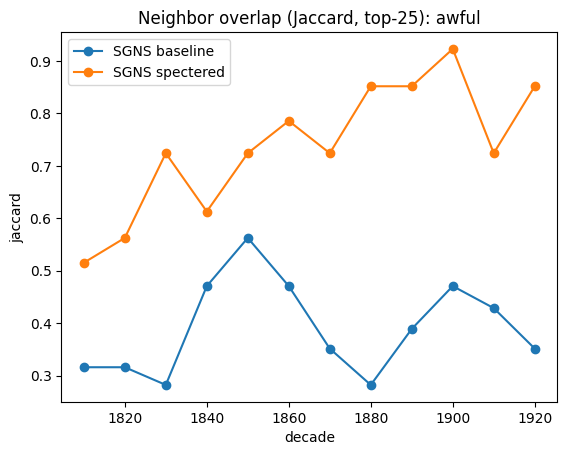

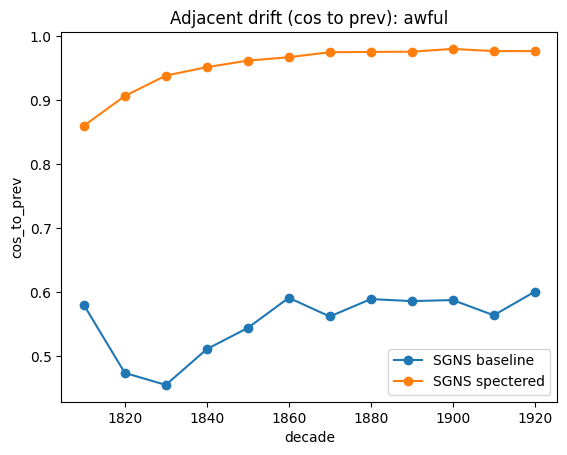


TERM: nice | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"delicate, discrimination, nicety, nicely, disquisitions, abstruse, subtle, scrupulous, intricate, minutely, discussing, perplexed"
1,1810,"delicate, nicest, nicety, delicacy, scrupulous, subtile, subtle, abstruse, critical, discrimination, distinctions, discernment"
2,1820,"delicate, nicest, fastidious, discriminations, distinctions, nicety, nicomedia, discrimination, reasoner, belgrade, spun, constantinople"
3,1830,"delicate, nicety, nicest, delicacy, intricate, refined, scrupulous, subtleties, abstruse, scrupulously, unlearned, genoa"
4,1840,"delicate, discrimination, nicest, council, chalcedon, constantinople, shrewd, antioch, nicety, nicomedia, discernment, tillemont"
5,1850,"delicate, nicety, dainty, delicacy, nicer, niceties, tact, shrewd, subtle, constantinople, nicest, propriety"
6,1860,"nicaea, delicate, comfortable, genteel, pretty, fine, clean, clever, nasty, charming, neat, queer"
7,1870,"papa, pretty, fastidious, very, delicate, nicaea, pleasant, nicety, neat, tidy, commonplace, distinctions"
8,1880,"cannes, pretty, funny, prim, clever, constance, nasty, delicate, clean, remarkably, very, neat"
9,1890,"pretty, touchy, clever, nicely, clean, very, queer, delicate, victual, awfully, gentlemanly, dainty"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"delicate, discrimination, nicety, nicely, disquisitions, abstruse, subtle, scrupulous, intricate, minutely, discussing, perplexed"
1,1810,"delicate, nicety, nicest, discrimination, delicacy, scrupulous, abstruse, intricate, critical, subtle, nicely, disquisitions"
2,1820,"delicate, nicest, nicety, delicacy, discrimination, scrupulous, subtile, abstruse, intricate, fastidious, distinctions, disquisitions"
3,1830,"delicate, nicety, nicest, delicacy, nicely, abstruse, scrupulous, refined, intricate, discrimination, subtile, niceties"
4,1840,"delicate, nicest, nicety, delicacy, abstruse, fastidious, niceties, intricate, discrimination, nicely, disquisitions, scrupulous"
5,1850,"delicate, nicety, delicacy, nicest, dainty, fastidious, niceties, nicer, nicely, exquisitely, disquisitions, abstruse"
6,1860,"delicate, nicety, dainty, delicacy, fastidious, nicest, nicely, nicer, subtile, shrewd, abstruse, discrimination"
7,1870,"delicate, nicety, fastidious, dainty, nicely, delicacy, nicest, nicer, shrewd, discernment, niceties, pretty"
8,1880,"delicate, nicety, fastidious, nicely, dainty, nicest, pretty, cannes, delicacy, very, nasty, genteel"
9,1890,"pretty, delicate, nicely, nicety, dainty, fastidious, very, queer, nasty, clean, tidy, clever"


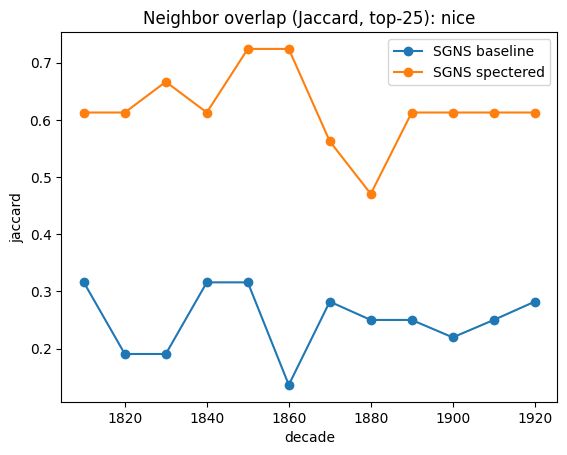

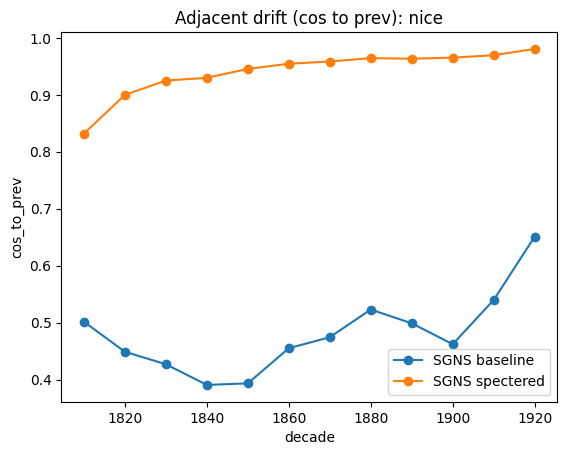


TERM: silly | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"foolish, impertinent, knaves, childish, trick, folks, impudent, knave, merry, stupid, joke, witty"
1,1810,"wench, coxcomb, foolish, puir, rascal, fantastical, conceited, childish, girl, fool, pitiful, senseless"
2,1820,"foolish, puir, frighten, fool, childish, pert, dinna, forsooth, unthinking, idle, chimerical, lucre"
3,1830,"foolish, rascal, bairns, thoughtless, frighten, wench, girl, childish, fool, woman, puir, idiot"
4,1840,"foolish, forsooth, credulous, fantastical, monstrous, wench, trick, mad, natured, jester, clever, fool"
5,1850,"foolish, fool, childish, pert, polly, puppy, funny, prattle, talkative, youngster, coxcomb, credulous"
6,1860,"foolish, queer, childish, natured, fool, stupid, boy, trick, girl, folks, thoughtless, lass"
7,1870,"foolish, stupid, lazy, wench, impertinent, eh, folks, ridiculous, jesting, papa, scared, deuce"
8,1880,"foolish, stupid, fool, nonsensical, pert, simpleton, nonsense, slanderous, presumptuous, uncivil, blockheads, conceited"
9,1890,"foolish, stupid, brat, daft, nonsense, unfashionable, foolery, braggart, absurd, frighten, antic, unkind"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"foolish, impertinent, knaves, childish, trick, folks, impudent, knave, merry, stupid, joke, witty"
1,1810,"foolish, wench, folks, childish, fool, impertinent, impudent, coxcomb, mad, merry, cheated, knave"
2,1820,"foolish, wench, childish, folks, fool, coxcomb, mad, trick, impudent, impertinent, frighten, puir"
3,1830,"foolish, wench, childish, knave, fool, rascal, mad, impertinent, puir, ugly, coxcomb, impudent"
4,1840,"foolish, wench, impertinent, mad, rascal, fool, childish, knave, impudent, coxcomb, puir, ugly"
5,1850,"foolish, wench, fool, impertinent, rascal, childish, coxcomb, thoughtless, blockhead, clever, knave, credulous"
6,1860,"foolish, thoughtless, coxcomb, childish, wench, fool, folks, impertinent, rascal, clever, pitiful, trick"
7,1870,"foolish, thoughtless, folks, fool, wench, childish, coxcomb, stupid, impertinent, blockhead, pitiful, rascal"
8,1880,"foolish, fool, wench, stupid, thoughtless, impertinent, pitiful, conceited, pert, childish, rascal, coxcomb"
9,1890,"foolish, stupid, blockhead, pitiful, fool, thoughtless, rascal, conceited, wench, impertinent, naughty, pert"


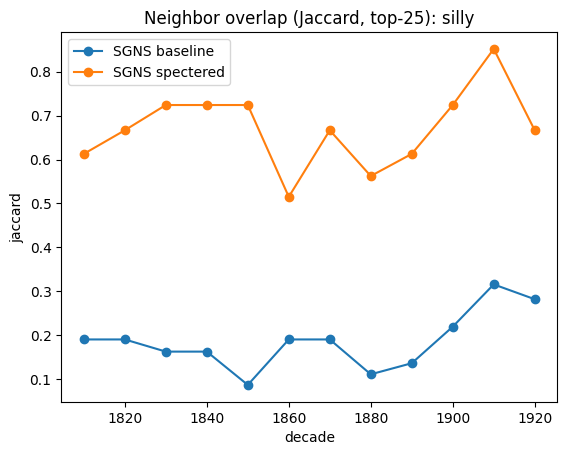

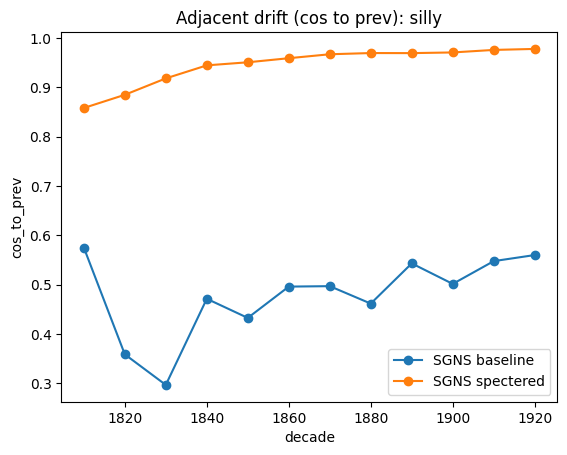


TERM: engine | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"engines, machine, tool, instrument, steam, pump, machinery, instruments, machines, wheels, spade, forge"
1,1810,"steam, machine, engines, instrument, tool, machinery, pump, boiler, cylinder, tools, grinding, friction"
2,1820,"machine, steam, engines, pump, piston, apparatus, machinery, cylinder, crank, boiler, instrument, watt"
3,1830,"engines, steam, machine, machinery, piston, boiler, wheels, crank, locomotive, wheel, pump, cylinder"
4,1840,"machine, engines, steam, machinery, locomotive, pump, wheel, wheels, piston, boiler, cylinder, boilers"
5,1850,"engines, machine, steam, locomotive, propelling, machinery, boiler, piston, locomotives, propel, pumping, hydraulic"
6,1860,"engines, steam, locomotive, machine, pump, boiler, machinery, boilers, propelled, screw, wheels, piston"
7,1870,"engines, steam, machine, locomotive, boiler, machinery, pump, piston, pumping, boilers, machines, cylinder"
8,1880,"steam, engines, locomotive, machine, fireman, boiler, pump, piston, plunger, cylinder, rotary, boilers"
9,1890,"engines, steam, machine, locomotive, boiler, turbines, pump, weisbach, dynamo, gasoline, piston, cog"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"engines, machine, tool, instrument, steam, pump, machinery, instruments, machines, wheels, spade, forge"
1,1810,"machine, engines, steam, instrument, tool, pump, machinery, instruments, machines, wheels, boiler, apparatus"
2,1820,"machine, steam, engines, instrument, pump, machinery, tool, apparatus, boiler, piston, machines, lever"
3,1830,"machine, engines, steam, pump, machinery, instrument, piston, apparatus, boiler, wheels, tool, machines"
4,1840,"machine, engines, steam, machinery, pump, wheel, piston, wheels, apparatus, crank, instrument, boiler"
5,1850,"machine, engines, steam, machinery, pump, locomotive, wheel, piston, wheels, crank, apparatus, boiler"
6,1860,"machine, engines, steam, locomotive, pump, machinery, wheel, boiler, boilers, wheels, lever, piston"
7,1870,"machine, engines, steam, locomotive, machinery, pump, boilers, boiler, wheel, piston, machines, wheels"
8,1880,"machine, engines, steam, locomotive, machinery, pump, boilers, boiler, piston, wheel, machines, pumping"
9,1890,"machine, engines, steam, locomotive, pump, boiler, machinery, boilers, piston, wheel, machines, crank"


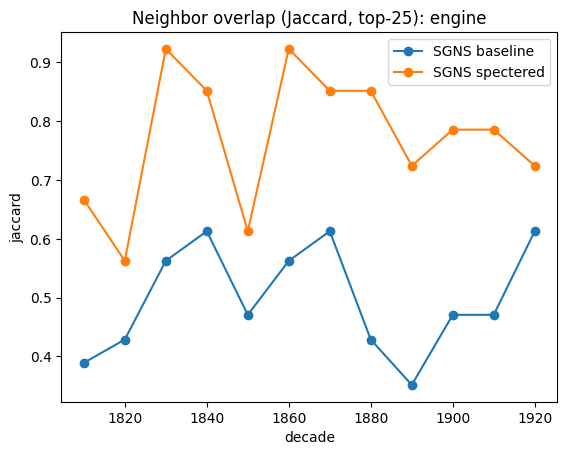

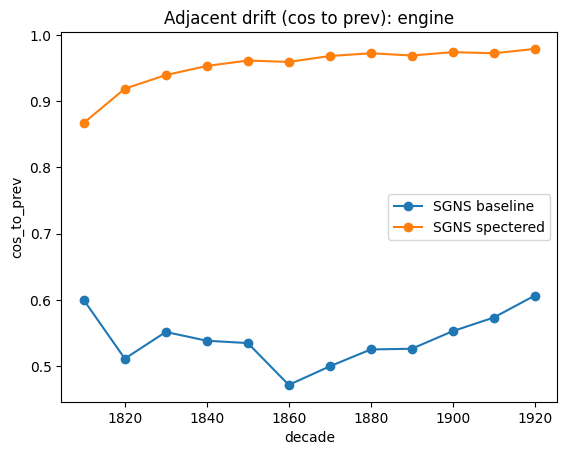


TERM: factory | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"petersburg, bruges, antwerp, commandant, hampton, birmingham, copenhagen, cruz, moscow, plymouth, montreal, panama"
1,1810,"factories, surat, batavia, fort, aleppo, smyrna, dutch, antwerp, canton, hamburgh, ostend, merchants"
2,1820,"factories, manufactory, leone, leghorn, manufactories, cochin, quay, trading, martinique, arsenal, pondicherry, bengal"
3,1830,"factories, trading, apothecaries, india, establishment, mill, manufactory, banking, manufactories, mills, investment, stationers"
4,1840,"factories, mills, mill, shop, workshops, manufactory, workshop, trading, ostend, establishment, superintendent, lowell"
5,1850,"factories, foundry, mill, mills, surat, working, workshop, shop, machinery, workshops, superintendent, killingworth"
6,1860,"manufactory, factories, manufactories, mills, workshop, shop, workshops, warehouse, miners, manufacture, forges, woolen"
7,1870,"factories, mills, manufactory, mill, workshop, shop, workshops, foundry, surat, manufacturing, machine, cotton"
8,1880,"factories, mill, mills, workshops, brewery, manufacturing, shop, shops, workshop, foundry, woolen, industries"
9,1890,"factories, surat, foundries, mill, workshop, mills, collieries, shop, workshops, manufactories, farm, shops"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"petersburg, bruges, antwerp, commandant, hampton, birmingham, copenhagen, cruz, moscow, plymouth, montreal, panama"
1,1810,"antwerp, canton, surat, fort, batavia, venetian, bruges, dutch, montreal, petersburg, factories, madras"
2,1820,"factories, antwerp, canton, bruges, dutch, surat, resident, lisbon, fort, trading, madras, petersburg"
3,1830,"factories, trading, ostend, resident, merchants, birmingham, canton, calcutta, montreal, manufactory, antwerp, batavia"
4,1840,"factories, trading, manufactory, ostend, calcutta, canton, birmingham, warehouse, carpenters, singapore, manufactories, warehouses"
5,1850,"factories, manufactory, trading, shop, superintendent, mills, manufactories, carpenters, birmingham, warehouse, canton, foundry"
6,1860,"factories, manufactory, shop, trading, manufactories, warehouse, mills, superintendent, carpenters, workshops, foundry, depot"
7,1870,"factories, manufactory, mills, shop, foundry, manufactories, warehouse, workshops, workshop, mill, superintendent, carpenters"
8,1880,"factories, manufactory, mills, foundry, manufactories, shop, workshops, mill, warehouse, workshop, grocers, docks"
9,1890,"factories, manufactory, mills, foundry, shop, manufactories, workshops, mill, workshop, brewery, surat, warehouse"


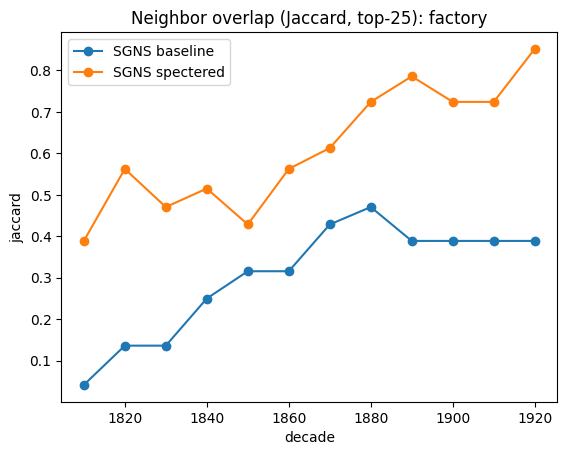

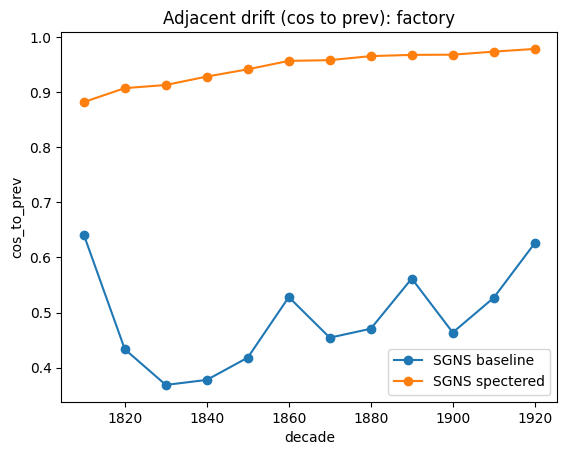


TERM: labor | baseline coverage=13 | spectered coverage=13

SGNS baseline neighbors (clean)


,decade,neighbors
0,1800,"labour, wages, workman, labourers, manufacturer, unproductive, husbandman, earned, labourer, manufacturing, regulates, trades"
1,1810,"labour, toil, earnings, husbandman, earn, hoc, menial, wages, drudgery, working, earned, labours"
2,1820,"labour, opus, earnings, unproductive, agricultural, products, wages, remuneration, earn, drudgery, labors, consumes"
3,1830,"labour, toil, wages, labors, industry, remuneration, labourer, earnings, labourers, labours, laborers, productiveness"
4,1840,"labour, toil, industry, wages, remuneration, earnings, laborious, earn, labourers, outlay, cost, employment"
5,1850,"labour, toil, industry, laborers, labourer, laborer, wages, productiveness, remuneration, labouring, producer, remunerated"
6,1860,"labour, wages, laborers, toil, remuneration, products, labourers, laborer, employment, industry, service, producers"
7,1870,"labour, toil, wages, labours, earnings, laborer, labors, industry, remuneration, labourer, cost, work"
8,1880,"labour, industry, toil, wages, exploitation, workpeople, labourers, laborer, machinery, cost, employment, laborers"
9,1890,"labour, toil, wages, industry, workingman, employment, laborers, labourers, capital, productivity, operatives, productive"



SGNS spectered neighbors (clean)


,decade,neighbors
0,1800,"labour, wages, workman, labourers, manufacturer, unproductive, husbandman, earned, labourer, manufacturing, regulates, trades"
1,1810,"labour, husbandman, wages, toil, earned, unproductive, earnings, earn, manufacturer, labourers, industry, cultivators"
2,1820,"labour, wages, earnings, husbandman, unproductive, toil, earn, labourer, earned, labourers, products, industry"
3,1830,"labour, toil, earnings, wages, unproductive, labourer, husbandman, industry, earn, labourers, products, labors"
4,1840,"labour, toil, wages, earnings, industry, remuneration, labourers, earn, labourer, unproductive, husbandman, employment"
5,1850,"labour, toil, earnings, wages, remuneration, industry, labourer, laborer, labourers, laborers, earn, productiveness"
6,1860,"labour, toil, wages, remuneration, earnings, industry, laborer, labourer, labourers, laborers, producer, unproductive"
7,1870,"labour, toil, wages, remuneration, earnings, industry, laborer, labourer, producers, laborers, labourers, unproductive"
8,1880,"labour, toil, wages, industry, earnings, remuneration, laborer, producers, labourers, labourer, laborers, unproductive"
9,1890,"labour, toil, wages, industry, laborer, earnings, labourer, producers, labourers, laborers, remuneration, employment"


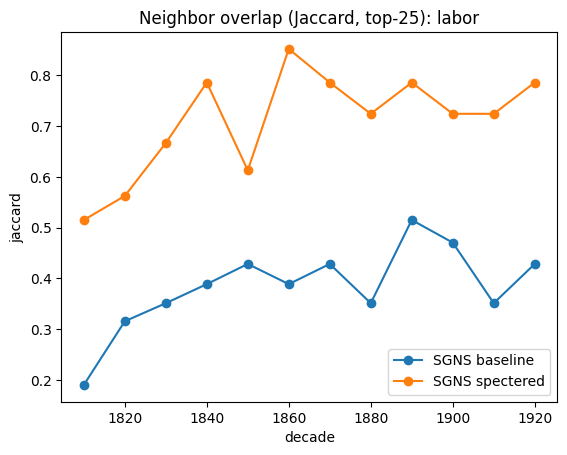

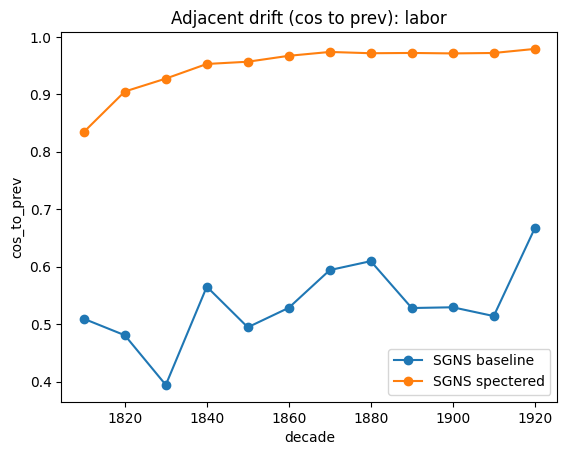

In [8]:
# Pick terms to compare (edit freely)
TARGET_WORDS = [
    "master", "slave", "negro", "cotton",
    "man", "woman", "child", "house", "room", "work", "money", "horse",
    "gay", "broadcast", "radio", "wireless", "telegraph", "telephone",
    "awful", "nice", "silly", "engine", "factory", "labor",
]

for term in TARGET_WORDS:
    print("\n" + "="*90)
    print(f"TERM: {term} | baseline coverage={coverage(term, sgns_aligned)} | spectered coverage={coverage(term, sgns_spectered)}")

    print("\nSGNS baseline neighbors (clean)")
    display(neighbor_trail(term, sgns_aligned, k=K_NEIGHBORS, keep_k=KEEP_K))

    print("\nSGNS spectered neighbors (clean)")
    display(neighbor_trail(term, sgns_spectered, k=K_NEIGHBORS, keep_k=KEEP_K))

    # Quantitative: neighbor overlap
    df_ov_base = neighbor_overlap(term, sgns_aligned, k=K_NEIGHBORS, keep_k=25)
    df_ov_spec = neighbor_overlap(term, sgns_spectered, k=K_NEIGHBORS, keep_k=25)
    plot_two_series(df_ov_base, df_ov_spec, x="decade", y="jaccard",
                    label_a="SGNS baseline", label_b="SGNS spectered",
                    title=f"Neighbor overlap (Jaccard, top-25): {term}")

    # Drift plot
    df_drift_base = adjacent_change(term, sgns_aligned)
    df_drift_spec = adjacent_change(term, sgns_spectered)
    plot_two_series(df_drift_base, df_drift_spec, x="decade", y="cos_to_prev",
                    label_a="SGNS baseline", label_b="SGNS spectered",
                    title=f"Adjacent drift (cos to prev): {term}")
